# TP1 - Carlos Jiménez - Desarrollo de Modelos Analíticos (Machine Learning) K5551

In [1]:
#install

%pip install -q pandas numpy matplotlib seaborn pandasql lightgbm scikit-learn

# uso de estas librerias

import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from pandasql import sqldf
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Ruta exacta
file_path = 'data_limpia.csv'

# Leer el archivo
data = pd.read_csv(file_path, sep='|', dtype = {'client_id': 'str'})

# Ver primeras filas
print(data.head())

  client_id  Target       Month First_product_dt Last_product_dt  \
0   5856970     1.0  2018-10-01       2013-10-23      2019-01-10   
1   6371753     0.0  2018-09-01       2015-07-29      2018-06-02   
2   5928737     0.0  2019-01-01       2016-08-31      2018-12-27   
3    475064     0.0  2018-12-01       2014-07-13      2017-11-30   
4   3615172     0.0  2018-09-01       2017-12-27      2017-12-28   

  CreditCard_Premium CreditCard_Active CreditCard_CoBranding Loan_Active  \
0                 No               Yes                    No          No   
1                 No                No                    No          No   
2                 No                No                    No          No   
3                 No               Yes                    No          No   
4                 No                No                    No          No   

  Mortgage_Active  ... CreditCard_Payment_External CreditCard_Payment_Cash  \
0              No  ...                         0.0      

In [3]:
data.shape

(238615, 77)

In [4]:
# Reviso columnas

data.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

In [5]:
print(data['Month'].dtype)
data['Month'].value_counts()

object


Month
2019-03-01    26547
2019-04-01    26547
2019-02-01    26512
2019-01-01    26503
2018-08-01    26502
2018-10-01    26501
2018-09-01    26501
2018-12-01    26501
2018-11-01    26501
Name: count, dtype: int64

In [6]:
data['periodo'] = pd.to_datetime(data['Month']).dt.strftime('%Y%m').astype(int)
data['periodo'].value_counts()

periodo
201903    26547
201904    26547
201902    26512
201901    26503
201808    26502
201810    26501
201809    26501
201812    26501
201811    26501
Name: count, dtype: int64

#Hago el case 7 de limpieza de una vez ya que son valores que no cambian como la region y la tarjeta de credito, si fueran variantes en el tiempo este paso deberia hacerlo en la ventana de entrenamiento solamente. Lo hago ya que me conviene tenerlo listo para todo el dataset.

# Use Case 7

Find Missing values and fill them

In [7]:
# Busco valores nulos

data.columns[data.isnull().any()].tolist()

['SavingAccount_Balance_Average', 'Region', 'CreditCard_Product']

In [8]:
"""
data_trainWindow['SavingAccount_Balance_Average'] = \
np.where(data_trainWindow.SavingAccount_Balance_Average.isnull(),
         data_trainWindow.SavingAccount_Balance_FirstDate - data_trainWindow.SavingAccount_Debits_Amounts + data_trainWindow.SavingAccount_Credits_Amounts ,
         data_trainWindow.SavingAccount_Balance_Average)
"""

"\ndata_trainWindow['SavingAccount_Balance_Average'] = np.where(data_trainWindow.SavingAccount_Balance_Average.isnull(),\n         data_trainWindow.SavingAccount_Balance_FirstDate - data_trainWindow.SavingAccount_Debits_Amounts + data_trainWindow.SavingAccount_Credits_Amounts ,\n         data_trainWindow.SavingAccount_Balance_Average)\n"

### Trabajamos primero con producto y region

In [9]:
#Reemplazemos valores vacios por nulos

for col in ['CreditCard_Product', 'Region']:
    data[col] = data[col].replace('', np.nan)

In [10]:
print("Nulos restantes (Product):", data['CreditCard_Product'].isna().sum())
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Product): 201979
Nulos restantes (Region): 185535


In [11]:
def mode_nonnull(s: pd.Series):
    vc = s.dropna().value_counts()
    return vc.index[0] if len(vc) else np.nan

# CreditCard_Product
prod_mode = data.groupby('client_id')['CreditCard_Product'].apply(mode_nonnull)
data['CreditCard_Product'] = data['CreditCard_Product'].fillna(data['client_id'].map(prod_mode))

# Region
reg_mode = data.groupby('client_id')['Region'].apply(mode_nonnull)
data['Region'] = data['Region'].fillna(data['client_id'].map(reg_mode))


In [12]:
print("Nulos restantes (Product):", data['CreditCard_Product'].isna().sum())
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Product): 73724
Nulos restantes (Region): 104


In [13]:
data['CreditCard_Product'].value_counts(dropna=False)

CreditCard_Product
J55660104XX012    77924
NaN               73724
J55660202XX012    54218
J55660124XX012    22386
J55660102XX012     3753
J55660123XX012     3429
J55660702XX012     2574
J55661002XX012      607
Name: count, dtype: int64

In [14]:
clientes_todo_nan = data.groupby('client_id')['CreditCard_Product'].apply(lambda s: s.isna().all()).sum()
print(f"Clientes sin producto en ningún periodo: {clientes_todo_nan}")

Clientes sin producto en ningún periodo: 8214


In [15]:
clientes_sin_producto = (
    data.groupby('client_id')['CreditCard_Product']
    .apply(lambda s: s.isna().all())
)

# Filtramos solo los que son True
clientes_sin_producto = clientes_sin_producto[clientes_sin_producto].index.tolist()

print(f"Total clientes sin producto en ningún período: {len(clientes_sin_producto)}")
print("Ejemplo de algunos IDs:", clientes_sin_producto[:10])

Total clientes sin producto en ningún período: 8214
Ejemplo de algunos IDs: ['1000199', '1000245', '1000847', '1001906', '100226', '1007730', '1007830', '1008223', '1008775', '1009217']


In [16]:
data[data['client_id'] == '5707524']

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
76,5707524,0.0,2018-12-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201812
17170,5707524,0.0,2018-10-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201810
39783,5707524,0.0,2018-09-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201809
50993,5707524,0.0,2018-11-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201811
107005,5707524,0.0,2019-01-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201901
116108,5707524,0.0,2019-04-01,2013-04-17,2017-05-18,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201904
210374,5707524,0.0,2019-02-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201902
217949,5707524,0.0,2018-08-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201808
225414,5707524,0.0,2019-03-01,2013-04-17,2017-05-18,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201903


In [17]:
cond = data['CreditCard_Product'].isna()
no_coinciden = data.loc[cond & (data['CreditCard_Active'] != 'No')]

print(f"Filas con producto nulo pero CreditCard_Active distinto de 'No': {len(no_coinciden)}")
no_coinciden.head()

Filas con producto nulo pero CreditCard_Active distinto de 'No': 2122


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
76,5707524,0.0,2018-12-01,2013-04-17,2017-05-18,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201812
253,7278197,0.0,2018-10-01,2018-04-29,2018-07-14,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,NaN,201810
258,5868104,0.0,2019-02-01,2014-04-08,2017-03-21,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,NaN,201902
287,4685382,0.0,2018-12-01,2018-03-14,2018-12-27,No,Yes,No,No,Yes,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,NaN,201812
460,1834285,0.0,2018-12-01,2009-04-19,2018-12-03,No,Yes,No,No,No,...,0.0,1.0,0.0,0.0,0.0,Yes,Yes,REGION CENTRO,NaN,201812


### Tenemos un problema, ya que aparecen con tarjeta de credito activa, pero no tienen datos en ninguno de los meses, estos clientes vamos a rellenar los datos.

In [18]:
# producto más común (excluyendo NaN)
most_common_product = data['CreditCard_Product'].mode(dropna=True)[0]
print("Producto más frecuente:", most_common_product)


Producto más frecuente: J55660104XX012


In [19]:
clientes_con_tarjeta_sin_producto = (
    data.groupby('client_id')
        .apply(lambda g: (g['CreditCard_Active'].eq('Yes').any()) and g['CreditCard_Product'].isna().all())
)

# filtrar los clientes True
clientes_con_tarjeta_sin_producto = clientes_con_tarjeta_sin_producto[clientes_con_tarjeta_sin_producto].index
print(f"Clientes con tarjeta activa pero sin producto asignado: {len(clientes_con_tarjeta_sin_producto)}")


Clientes con tarjeta activa pero sin producto asignado: 341


/tmp/ipykernel_7618/3955696498.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['CreditCard_Active'].eq('Yes').any()) and g['CreditCard_Product'].isna().all())


In [20]:
mask = data['client_id'].isin(clientes_con_tarjeta_sin_producto)
data.loc[mask, 'CreditCard_Product'] = data.loc[mask, 'CreditCard_Product'].fillna(most_common_product)


In [21]:
cond = data['CreditCard_Product'].isna()
no_coinciden = data.loc[cond & (data['CreditCard_Active'] != 'No')]

print(f"Filas con producto nulo pero CreditCard_Active distinto de 'No': {len(no_coinciden)}")
no_coinciden.head()


Filas con producto nulo pero CreditCard_Active distinto de 'No': 0


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo


### Coloco sin producto a los que no tienen tarjeta en ningun momento

In [22]:
data['CreditCard_Product'] = data['CreditCard_Product'].fillna('SIN_PRODUCTO')

### Hacemos lo mismo con region

In [23]:
# región más común (excluyendo NaN)
most_common_region = data['Region'].mode(dropna=True)[0]
print("Region más frecuente:", most_common_region)


Region más frecuente: BUENOS AIRES


In [24]:
data['Region'] = data['Region'].fillna(most_common_region)
print("Nulos restantes (Region):", data['Region'].isna().sum())

Nulos restantes (Region): 0


### Ahora trabajamos con SavingAccount_Balance_Average

In [25]:
cond = data['SavingAccount_Balance_Average'].isna()

print(f"Filas con SavingAccount_Balance_Average = NaN: {cond.sum()}")
data[cond].head()

Filas con SavingAccount_Balance_Average = NaN: 5


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
81353,4473325,0.0,2018-12-01,2008-05-27,2017-05-18,Yes,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,AMBA Resto,J55660104XX012,201812
81354,4837071,1.0,2018-12-01,2013-02-21,2018-09-04,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION CUYO,SIN_PRODUCTO,201812
81356,4525957,1.0,2019-01-01,2012-10-16,2016-08-31,Yes,Yes,No,No,No,...,0.0,1.0,0.0,0.0,0.0,Yes,Yes,CABA Centro/Norte,J55661002XX012,201901
81361,4842337,1.0,2019-02-01,2010-07-27,2018-07-06,No,Yes,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,J55660202XX012,201902
238612,6412619,0.0,2019-01-01,2015-07-08,2018-06-02,No,No,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION PATAGONICA,SIN_PRODUCTO,201901


Son pocos pero igual vamos a usar la logica correcta para completar

In [26]:
mask = data['SavingAccount_Balance_Average'].isna()

data.loc[mask, 'SavingAccount_Balance_Average'] = (
    (data.loc[mask, 'SavingAccount_Balance_FirstDate'] +
     data.loc[mask, 'SavingAccount_Balance_LastDate']) / 2
)

In [27]:
cond = data['SavingAccount_Balance_Average'].isna()

print(f"Filas con SavingAccount_Balance_Average = NaN: {cond.sum()}")
data[cond].head()

Filas con SavingAccount_Balance_Average = NaN: 0


,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo


In [28]:
cols = [
    'client_id', 'periodo',
    'SavingAccount_Balance_FirstDate',
    'SavingAccount_Total_Amount',
    'SavingAccount_Balance_Average'
]

data.loc[(data['client_id'] == '4837071') & (data['periodo'] == 201812), cols]


,client_id,periodo,SavingAccount_Balance_FirstDate,SavingAccount_Total_Amount,SavingAccount_Balance_Average
81354,4837071,201812,43.53,21364.52,5325.79


In [29]:
data.columns[data.isnull().any()].tolist()

[]

In [30]:
data.shape

(238615, 78)

## Listo, eliminamos los nulls correctamente

# Use Case 1

Take only clients with 9 Months of Data. Why?


In [31]:
# 1️⃣ Identificar cuántos periodos distintos tiene cada client_id
client_period_counts = data.groupby('client_id')['periodo'].nunique()

client_period_counts

client_id
1000199    9
1000245    9
1000847    9
1001232    9
1001450    9
          ..
99842      9
998420     9
998768     9
99926      9
999462     9
Name: periodo, Length: 26560, dtype: int64

In [32]:
# cuántos meses distintos hay en el dataset (debería dar 9)
expected_months = data['periodo'].nunique()

expected_months

9

In [33]:
# 1) contar filas por cliente y mes
g = (data.groupby(['client_id','periodo'])
         .size()
         .reset_index(name='rows_per_month'))

g

,client_id,periodo,rows_per_month
0,1000199,201808,1
1,1000199,201809,1
2,1000199,201810,1
3,1000199,201811,1
4,1000199,201812,1
...,...,...,...
238610,999462,201812,1
238611,999462,201901,1
238612,999462,201902,1
238613,999462,201903,1


In [34]:
# 2) quedarnos solo con los meses donde ese cliente aparece exactamente 1 vez
g1 = g[g['rows_per_month'] == 1]

g1

,client_id,periodo,rows_per_month
0,1000199,201808,1
1,1000199,201809,1
2,1000199,201810,1
3,1000199,201811,1
4,1000199,201812,1
...,...,...,...
238610,999462,201812,1
238611,999462,201901,1
238612,999462,201902,1
238613,999462,201903,1


In [35]:
# 3) clientes que cumplen con cobertura completa (1 vez en cada mes)
valid_clients = (g1.groupby('client_id')['periodo']
                   .nunique()
                   .pipe(lambda s: s[s == expected_months])
                   .index)

valid_clients

Index(['1000199', '1000245', '1000847', '1001232', '1001450', '1001906',
       '100226', '1002452', '1002681', '1002739',
       ...
       '997539', '997836', '9982', '998375', '998377', '99842', '998420',
       '998768', '99926', '999462'],
      dtype='object', name='client_id', length=26483)

In [36]:
# Lista de clientes válidos
clientes_9m = list(valid_clients)

In [37]:
# Cantidad de clientes válidos
cantidad_clientes_9m = len(valid_clients)

cantidad_clientes_9m

26483

In [38]:
data_9m = data[data['client_id'].isin(valid_clients)]

In [39]:
data_9m

,client_id,Target,Month,First_product_dt,Last_product_dt,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,...,CreditCard_Payment_Cash,CreditCard_Payment_Web,CreditCard_Payment_ATM,CreditCard_Payment_TAS,Investment_Numbers,Mobile,Email,Region,CreditCard_Product,periodo
0,5856970,1.0,2018-10-01,2013-10-23,2019-01-10,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,1.0,Yes,Yes,AMBA Resto,J55660202XX012,201810
1,6371753,0.0,2018-09-01,2015-07-29,2018-06-02,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION CENTRO,SIN_PRODUCTO,201809
2,5928737,0.0,2019-01-01,2016-08-31,2018-12-27,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,201901
3,475064,0.0,2018-12-01,2014-07-13,2017-11-30,No,Yes,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION CUYO,J55660202XX012,201812
4,3615172,0.0,2018-09-01,2017-12-27,2017-12-28,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION CENTRO,SIN_PRODUCTO,201809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238610,6448833,0.0,2019-03-01,2016-05-09,2019-04-02,No,No,No,No,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,201903
238611,6377583,0.0,2019-04-01,2015-06-03,2019-01-04,No,Yes,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,Yes,BUENOS AIRES,J55660104XX012,201904
238612,6412619,0.0,2019-01-01,2015-07-08,2018-06-02,No,No,No,Yes,No,...,0.0,0.0,0.0,0.0,0.0,Yes,No,REGION PATAGONICA,SIN_PRODUCTO,201901
238613,5542402,0.0,2019-04-01,2012-09-13,2012-09-13,No,Yes,No,No,No,...,0.0,0.0,1.0,0.0,0.0,No,Yes,REGION NORTE GRANDE ARGENTINO,J55660104XX012,201904


In [40]:
client_counts = data_9m['client_id'].value_counts().reset_index()
client_counts.columns = ['client_id', 'meses']

In [41]:
client_counts

,client_id,meses
0,5856970,9
1,6371753,9
2,5928737,9
3,475064,9
4,3615172,9
...,...,...
26478,1988103,9
26479,4908119,9
26480,5744054,9
26481,3028372,9


# Use Case 1

Take only clients without Active Package. Be careful with the month!

In [42]:
data['Package_Active'].value_counts()

Package_Active
No     234177
Yes      4438
Name: count, dtype: int64

In [43]:
data_sinPaquete = data[(data['Package_Active'] == 'No') & (data['periodo'] == 201901)][['client_id']]
data_sinPaquete

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [44]:
# Que no tenga Cobranding

data['CreditCard_CoBranding'].value_counts()

CreditCard_CoBranding
No     213049
Yes     25566
Name: count, dtype: int64

In [45]:
data_cobranding = data[(data['CreditCard_CoBranding'] == 'No') & (data['periodo'] == 201901)][['client_id']]
data_cobranding

,client_id
2,5928737
10,6018047
11,5359038
16,6890812
20,115383
...,...
238573,6570413
238574,6258895
238585,6397274
238586,6007291


In [46]:
# Junto todo

data_final = client_counts.merge(data_sinPaquete, how='inner', on='client_id')\
                     .merge(data_cobranding, how='inner', on='client_id')

data_final.shape

(23191, 2)

In [47]:
data_final

,client_id,meses
0,5856970,9
1,6371753,9
2,5928737,9
3,475064,9
4,3615172,9
...,...,...
23186,4221845,9
23187,1988103,9
23188,4908119,9
23189,3028372,9


# Use Case 2

Prediction Windows → Last two Months
Lead Windows → Only one Month
Historical Windows → Rest of Months

In [48]:
# Prediction window

train_window = [201808, 201809, 201810, 201811, 201812, 201901]
train_end = 201901
lead_month = 201902
pred_window = [201903, 201904]

data_TGT = data[data['periodo'].isin(pred_window)][['client_id', 'Target']]

data_TGT.client_id.value_counts()

client_id
6867662    2
5775560    2
5800470    2
3540244    2
2739521    2
          ..
672542     1
264018     1
6884923    1
6393208    1
4424661    1
Name: count, Length: 26551, dtype: int64

In [49]:
# Prediction window

data_TGT = data[(data['periodo'].isin(pred_window)) & (data['Target'] == 1)][['client_id']].drop_duplicates()
data_TGT.client_id.value_counts()

client_id
5025967    1
937183     1
2799736    1
5425606    1
1809861    1
          ..
786498     1
6937189    1
6861415    1
938881     1
943184     1
Name: count, Length: 6926, dtype: int64

In [50]:
data_TGT['TGT'] = 1

# Drop the existing 'TGT' column from data_final before merging
if 'TGT' in data_final.columns:
  data_final = data_final.drop('TGT', axis=1)

data_final = data_final.merge(data_TGT, how='left', on='client_id')

data_final['TGT'] = data_final['TGT'].fillna(0)

In [51]:
data_final['TGT'].value_counts()

TGT
0.0    16368
1.0     6823
Name: count, dtype: int64

In [52]:
# Training Window

data_trainWindow = data[data['periodo'].isin(train_window)]

len(data_trainWindow['client_id'].unique())

26509

In [53]:
data_trainWindow = data_trainWindow.merge(data_final[['client_id']], how='inner', on='client_id')
len(data_trainWindow['client_id'].unique())

23191

In [54]:
data_trainWindow['periodo'].value_counts().sort_index()

periodo
201808    23191
201809    23191
201810    23191
201811    23191
201812    23191
201901    23191
Name: count, dtype: int64

In [55]:
data_trainWindow.shape

(139146, 78)

In [56]:
data_trainWindow['SavingAccount_Active_ARG'].value_counts()

SavingAccount_Active_ARG
Yes    101033
No      38113
Name: count, dtype: int64

# Use Case 3

Is the target Balanced or Unbalanced?
How can you balance the data frame 50/50?

In [57]:
# Mostrar el balance de la base
porcentajes = (
    data.groupby(['periodo', 'Target'])
    .size()
    .reset_index(name='count')
)

porcentajes['total_periodo'] = porcentajes.groupby('periodo')['count'].transform('sum')

porcentajes['porcentaje'] = (porcentajes['count'] / porcentajes['total_periodo']) * 100

porcentajes # Si esta balanceada la base, tiene mas o menos 26% todos los meses. Para balancearlo 50/50 se podria agarrar muestras aleatorias del 74% hasta reducirlo hasta que quede una base de 50%, procurando mantener clientes que tengamos 9 meses de datos.

,periodo,Target,count,total_periodo,porcentaje
0,201808,0.0,19587,26502,73.907630
1,201808,1.0,6915,26502,26.092370
2,201809,0.0,19586,26501,73.906645
3,201809,1.0,6915,26501,26.093355
4,201810,0.0,19586,26501,73.906645
5,201810,1.0,6915,26501,26.093355
6,201811,0.0,19586,26501,73.906645
7,201811,1.0,6915,26501,26.093355
8,201812,0.0,19586,26501,73.906645
9,201812,1.0,6915,26501,26.093355


# Use Case 4

Find Data Types

In [58]:
data_trainWindow.dtypes

client_id              object
Target                float64
Month                  object
First_product_dt       object
Last_product_dt        object
                       ...   
Mobile                 object
Email                  object
Region                 object
CreditCard_Product     object
periodo                 int64
Length: 78, dtype: object

# Use Case 8

Analyze SavingAccount_Balance_Average.
Apply this methodology to others features.

#SavingAccount_Balance_Average

In [59]:
# Outliers

data_trainWindow[['SavingAccount_Balance_Average'] ].describe()

,SavingAccount_Balance_Average
count,1.391460e+05
mean,4.094833e+03
std,2.293939e+04
min,-5.665900e+02
25%,0.000000e+00
50%,1.032500e+01
75%,1.473138e+03
max,1.771201e+06


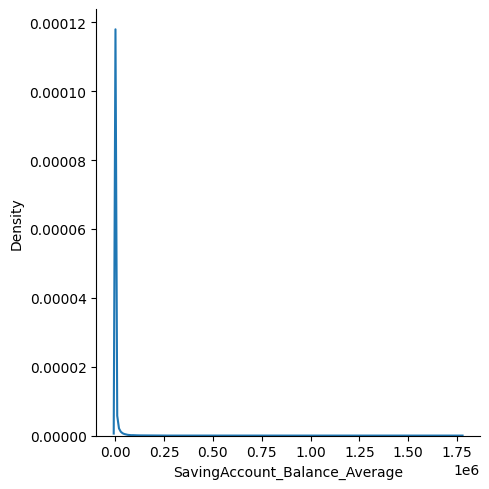

In [60]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [61]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Balance_Average'].std()
three_sigma

np.float64(68818.15942060263)

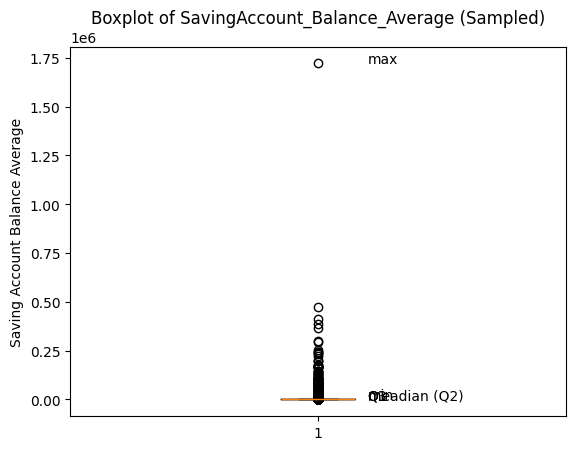

In [62]:
# Box Plot

# Sample the data to avoid plotting too many points
sample_size = 10000  # You can adjust this number as needed
sampled_data = data_trainWindow['SavingAccount_Balance_Average'].sample(n=sample_size, random_state=42)

plt.boxplot(sampled_data)

# add labels for five number summary
plt.text(x = 1.1, y = sampled_data.min(), s ='min')
plt.text(x = 1.1, y = sampled_data.quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = sampled_data.median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = sampled_data.quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = sampled_data.max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of SavingAccount_Balance_Average (Sampled)')
plt.ylabel('Saving Account Balance Average')

# display the plot
plt.show()

In [63]:
Q1 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.25)
Q3 = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  3682.84375  es un outlier


In [64]:
print('Todo lo que sea mayor a ' , data_trainWindow['SavingAccount_Balance_Average'].quantile(0.95) , ' es un outlier')

Todo lo que sea mayor a  17043.66  es un outlier


In [65]:
outlier = data_trainWindow['SavingAccount_Balance_Average'].quantile(0.99)

data_trainWindow['SavingAccount_Balance_Average'] = np.where(data_trainWindow['SavingAccount_Balance_Average'] > outlier, outlier, data_trainWindow['SavingAccount_Balance_Average'] )

In [66]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Balance_Average'].std()
three_sigma

np.float64(29717.142543139336)

In [67]:
data_trainWindow['SavingAccount_Balance_Average'] = np.where(data_trainWindow['SavingAccount_Balance_Average'] > three_sigma, three_sigma, data_trainWindow['SavingAccount_Balance_Average'] )

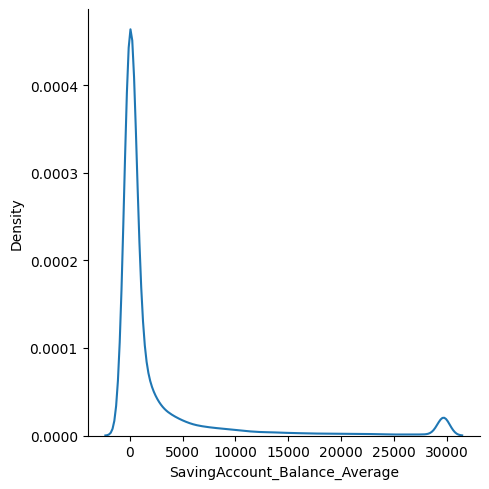

In [68]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Balance_Average'], kind='kde')

# display the plot
plt.show()

In [69]:
data_trainWindow['SavingAccount_Balance_Average'].describe()

count    139146.000000
mean       2508.848544
std        6226.592558
min        -566.590000
25%           0.000000
50%          10.325000
75%        1473.137500
max       29717.142543
Name: SavingAccount_Balance_Average, dtype: float64

#CreditCard_Total_Spending



In [70]:
# Outliers

data_trainWindow[['CreditCard_Total_Spending'] ].describe()

,CreditCard_Total_Spending
count,139146.00000
mean,4226.44988
std,7290.00507
min,-30164.77000
25%,0.00000
50%,1482.71000
75%,5656.14750
max,176554.25000


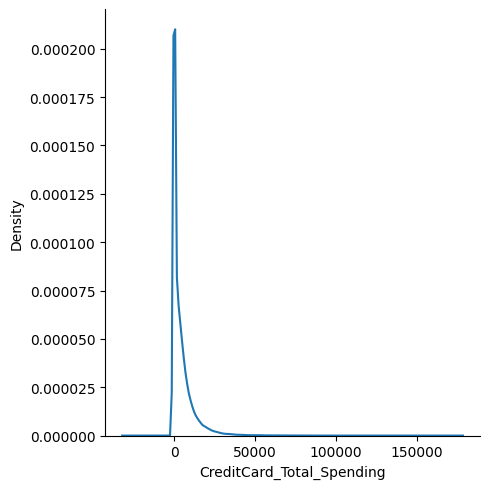

In [71]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [72]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['CreditCard_Total_Spending'].std()
three_sigma

np.float64(21870.01520929554)

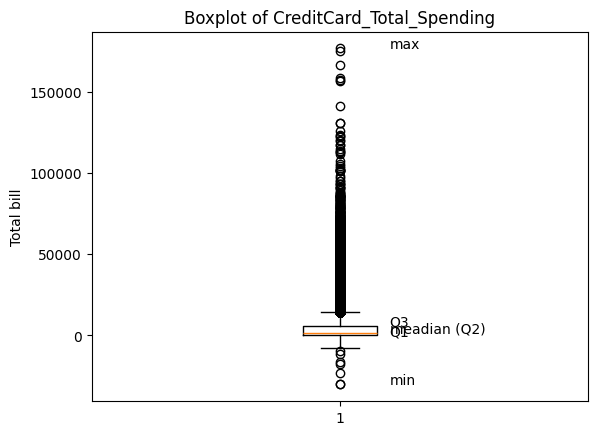

In [73]:
# Box Plot

plt.boxplot(data_trainWindow['CreditCard_Total_Spending'])

# add labels for five number summary
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].min(), s ='min')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = data_trainWindow['CreditCard_Total_Spending'].max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of CreditCard_Total_Spending')
plt.ylabel('Total bill')

# display the plot
plt.show()

In [74]:
Q1 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.25)
Q3 = data_trainWindow['CreditCard_Total_Spending'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  14140.368750000001  es un outlier


In [75]:
print('Todo lo que sea mayor a ' , data_trainWindow['CreditCard_Total_Spending'].quantile(0.95) , ' es un outlier')

Todo lo que sea mayor a  17131.6725  es un outlier


In [76]:
outlier = data_trainWindow['CreditCard_Total_Spending'].quantile(0.99)

data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] > outlier, outlier, data_trainWindow['CreditCard_Total_Spending'] )

In [77]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['CreditCard_Total_Spending'].std()
three_sigma

np.float64(18749.021112125287)

In [78]:
data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] > three_sigma, three_sigma, data_trainWindow['CreditCard_Total_Spending'] )

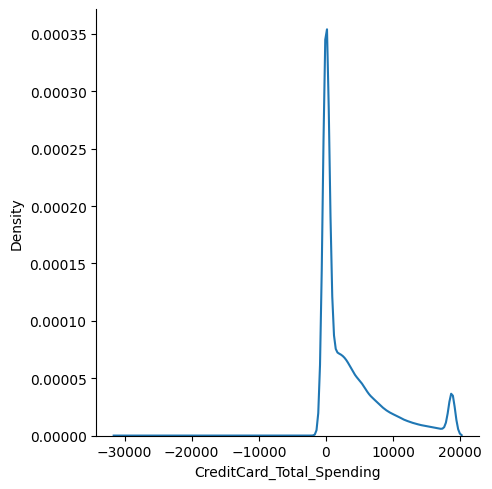

In [79]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [80]:
#Revisamos los negativos

negativos_count = (data_trainWindow['CreditCard_Total_Spending'] < 0).sum()
print("Cantidad de filas con valores negativos:", negativos_count)

positivos_count = (data_trainWindow['CreditCard_Total_Spending'] >= 0).sum()
print("Cantidad de filas con valores positivos:", positivos_count)

Cantidad de filas con valores negativos: 62
Cantidad de filas con valores positivos: 139084


##reemplazo valores negativos con 3sigma

In [81]:
data_trainWindow['CreditCard_Total_Spending'] = np.where(data_trainWindow['CreditCard_Total_Spending'] < 0, three_sigma, data_trainWindow['CreditCard_Total_Spending'] )

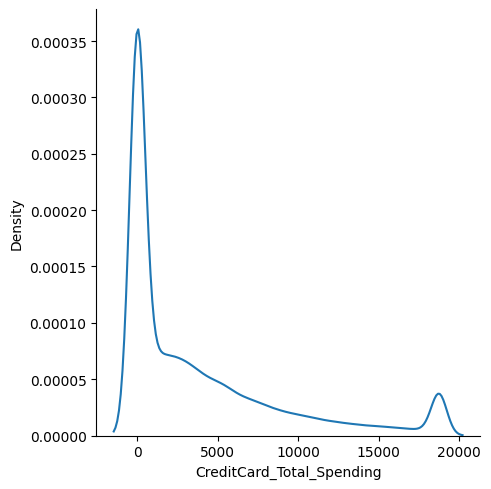

In [82]:
# plot a distribution plot
sns.displot(data_trainWindow['CreditCard_Total_Spending'], kind='kde')

# display the plot
plt.show()

In [83]:
data_trainWindow['CreditCard_Total_Spending'].describe()

count    139146.000000
mean       3781.875490
std        5170.601013
min           0.000000
25%           0.000000
50%        1488.460000
75%        5665.242500
max       18749.021112
Name: CreditCard_Total_Spending, dtype: float64

#SavingAccount_Days_with_use

In [84]:
# Outliers

data_trainWindow[['SavingAccount_Days_with_use'] ].describe()

,SavingAccount_Days_with_use
count,139146.000000
mean,2.512685
std,3.831400
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,41.000000


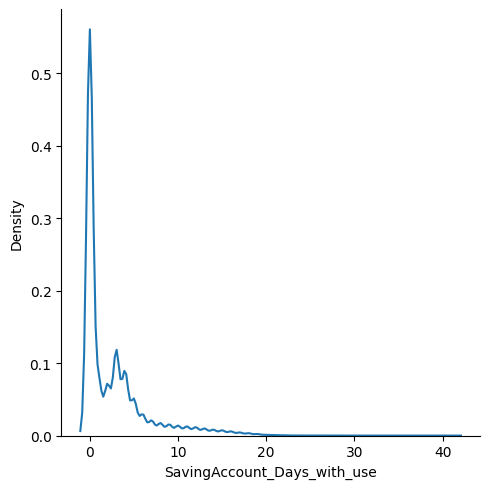

In [85]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Days_with_use'], kind='kde')

# display the plot
plt.show()

In [86]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Days_with_use'].std()
three_sigma

np.float64(11.494198755310885)

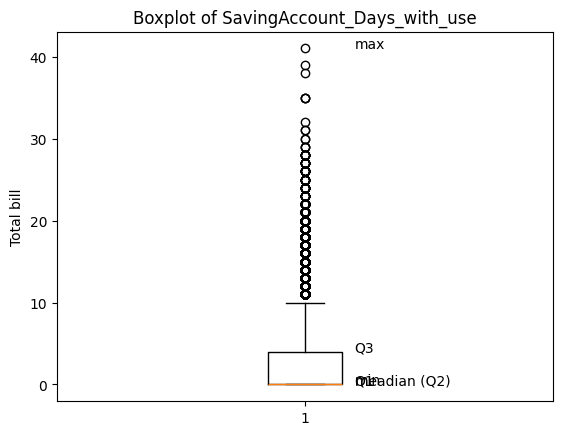

In [87]:
# Box Plot

plt.boxplot(data_trainWindow['SavingAccount_Days_with_use'])

# add labels for five number summary
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].min(), s ='min')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.25), s ='Q1')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].median(), s ='meadian (Q2)')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.75), s ='Q3')
plt.text(x = 1.1, y = data_trainWindow['SavingAccount_Days_with_use'].max(), s ='max')


# add the graph title and axes labels
plt.title('Boxplot of SavingAccount_Days_with_use')
plt.ylabel('Total bill')

# display the plot
plt.show()

In [88]:
Q1 = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.25)
Q3 = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.75)

print('Todo lo que sea mayor a ' , Q3 + (1.5 * (Q3 - Q1)), ' es un outlier')

Todo lo que sea mayor a  10.0  es un outlier


In [89]:
print('Todo lo que sea mayor a ' , data_trainWindow['SavingAccount_Days_with_use'].quantile(0.92) , ' es un outlier')

Todo lo que sea mayor a  9.0  es un outlier


In [90]:
outlier = data_trainWindow['SavingAccount_Days_with_use'].quantile(0.99)

data_trainWindow['SavingAccount_Days_with_use'] = np.where(data_trainWindow['SavingAccount_Days_with_use'] > outlier, outlier, data_trainWindow['SavingAccount_Days_with_use'] )

In [91]:
# 3 sigmas

three_sigma = 3 * data_trainWindow['SavingAccount_Days_with_use'].std()
three_sigma

np.float64(11.229661310383698)

In [92]:
data_trainWindow['SavingAccount_Days_with_use'] = np.where(data_trainWindow['SavingAccount_Days_with_use'] > three_sigma, three_sigma, data_trainWindow['SavingAccount_Days_with_use'] )

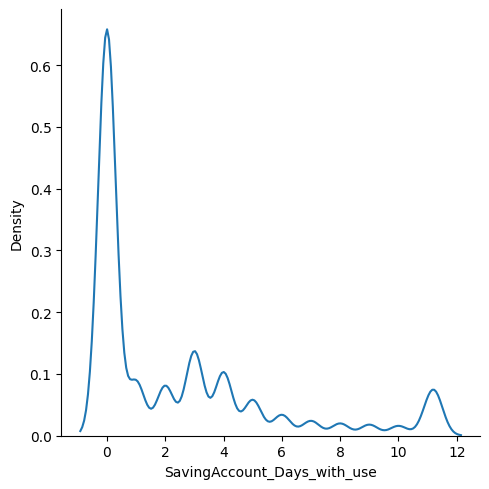

In [93]:
# plot a distribution plot
sns.displot(data_trainWindow['SavingAccount_Days_with_use'], kind='kde')

# display the plot
plt.show()

In [94]:
data_trainWindow['SavingAccount_Days_with_use'].describe()

count    139146.000000
mean          2.338040
std           3.257995
min           0.000000
25%           0.000000
50%           0.000000
75%           4.000000
max          11.229661
Name: SavingAccount_Days_with_use, dtype: float64

# Use Case 6
Find Transform Features
Find possible Transform Features (ordinal features)
Find Identity Features
Create Data Frame with Identity and Transform Features

## Identity features

In [95]:
identity_cols = [
    'client_id',
    'CreditCard_Premium',
    'CreditCard_Active',
    'CreditCard_CoBranding',
    'Loan_Active',
    'Mortgage_Active',
    'SavingAccount_Active_ARG_Salary',
    'SavingAccount_Active_ARG',
    'SavingAccount_Active_DOLLAR',
    'DebitCard_Active',
    'Investment_Active',
    'Package_Active',
    'Insurance_Life',
    'Insurance_Home',
    'Insurance_Accidents',
    'Insurance_Mobile',
    'Insurance_ATM',
    'Insurance_Unemployment',
    'Sex',
    'Region',
    'CreditCard_Product',
    'Client_Age_grp' #No es identity
]

data_if = data_trainWindow[data_trainWindow['periodo'] == 201901][identity_cols]

In [96]:
data_if.columns

Index(['client_id', 'CreditCard_Premium', 'CreditCard_Active',
       'CreditCard_CoBranding', 'Loan_Active', 'Mortgage_Active',
       'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG',
       'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active',
       'Package_Active', 'Insurance_Life', 'Insurance_Home',
       'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM',
       'Insurance_Unemployment', 'Sex', 'Region', 'CreditCard_Product',
       'Client_Age_grp'],
      dtype='object')

In [97]:
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,Client_Age_grp
2,5928737,No,No,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 30 y 39 años
8,6018047,Yes,Yes,No,No,No,No,Yes,No,Yes,...,No,No,No,No,No,No,M,BUENOS AIRES,J55660104XX012,Entre 60 y 64 años
9,5359038,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,J55660104XX012,Entre 40 y 49 años
11,6890812,No,No,No,Yes,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,M,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 40 y 49 años
13,115383,No,No,No,No,No,No,Yes,No,No,...,No,No,No,No,No,No,M,AMBA Resto,SIN_PRODUCTO,Mayor a 70 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,6570413,No,Yes,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,F,REGION PATAGONICA,J55660104XX012,Entre 30 y 39 años
139132,6258895,No,No,No,No,No,No,Yes,Yes,Yes,...,No,No,No,No,No,No,F,BUENOS AIRES,SIN_PRODUCTO,Entre 30 y 39 años
139138,6397274,No,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,No,M,REGION CENTRO,J55660104XX012,Entre 40 y 49 años
139139,6007291,Yes,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,No,F,CABA Centro/Norte,J55660202XX012,Entre 40 y 49 años


In [98]:
data_if.dtypes

client_id                          object
CreditCard_Premium                 object
CreditCard_Active                  object
CreditCard_CoBranding              object
Loan_Active                        object
Mortgage_Active                    object
SavingAccount_Active_ARG_Salary    object
SavingAccount_Active_ARG           object
SavingAccount_Active_DOLLAR        object
DebitCard_Active                   object
Investment_Active                  object
Package_Active                     object
Insurance_Life                     object
Insurance_Home                     object
Insurance_Accidents                object
Insurance_Mobile                   object
Insurance_ATM                      object
Insurance_Unemployment             object
Sex                                object
Region                             object
CreditCard_Product                 object
Client_Age_grp                     object
dtype: object

## Reemplazar False / True , No / Yes  por 0 y 1

In [99]:
# Reemplazar False / True , No / Yes  por 0 y 1

In [100]:
# Solo columnas no numéricas
non_numeric_cols = data_if.select_dtypes(include=['object', 'bool']).columns

In [101]:
binary_cols = [
    col for col in non_numeric_cols
    if data_if[col].dropna().nunique() == 2
]

print("Columnas binarias (Yes/No o True/False):")
print(binary_cols)


Columnas binarias (Yes/No o True/False):
['CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active', 'Sex']


In [102]:
for col in binary_cols:
    print(f"{col}: {data_if[col].dropna().unique()}")

CreditCard_Premium: ['No' 'Yes']
CreditCard_Active: ['No' 'Yes']
Loan_Active: ['No' 'Yes']
Mortgage_Active: ['No' 'Yes']
SavingAccount_Active_ARG_Salary: ['No' 'Yes']
SavingAccount_Active_ARG: ['Yes' 'No']
SavingAccount_Active_DOLLAR: ['Yes' 'No']
DebitCard_Active: ['Yes' 'No']
Investment_Active: ['No' 'Yes']
Sex: ['M' 'F']


In [103]:
# columnas no numéricas
non_numeric = data_if.select_dtypes(include=['object','bool','category']).columns

binary_cols = []
for c in non_numeric:
    vals = (data_if[c]
            .dropna()
            .astype(str)
            .str.strip()
            .str.upper()
            .unique())
    # si TODOS sus valores pertenecen al conjunto binario, la tomamos
    if set(vals).issubset({'YES','NO','TRUE','FALSE','Y','N','0','1','M','F'}):
        binary_cols.append(c)

print("Binarias detectadas:", binary_cols)

Binarias detectadas: ['CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding', 'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR', 'DebitCard_Active', 'Investment_Active', 'Package_Active', 'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex']


In [104]:
def to_binary01(series: pd.Series) -> pd.Series:
    s = series.astype('string').str.strip().str.upper()
    s = s.replace({'SÍ': 'SI'})  # por si aparece con tilde
    # mapeo principal
    mapped = s.replace({
        'YES': 1, 'TRUE': 1, 'Y': 1, 'SI': 1, '1': 1, 'M': 1,
        'NO': 0,  'FALSE': 0, 'N': 0, '0': 0, 'F': 0
    })
    # manejar bool reales si los hubiera
    mapped = mapped.replace({True: 1, False: 0})
    # dejar NaN como NaN
    mapped = mapped.replace({'NAN': np.nan})
    # tipo compacto con nulos
    return mapped.astype('Int8')

for col in binary_cols:
    data_if[col] = to_binary01(data_if[col])

# verificación
for col in binary_cols[:8]:
    print(col, data_if[col].unique())

/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.re

CreditCard_Premium <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
CreditCard_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
CreditCard_CoBranding <IntegerArray>
[0]
Length: 1, dtype: Int8
Loan_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
Mortgage_Active <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
SavingAccount_Active_ARG_Salary <IntegerArray>
[0, 1]
Length: 2, dtype: Int8
SavingAccount_Active_ARG <IntegerArray>
[1, 0]
Length: 2, dtype: Int8
SavingAccount_Active_DOLLAR <IntegerArray>
[1, 0]
Length: 2, dtype: Int8


/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.replace({
/tmp/ipykernel_7618/2576411563.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mapped = s.re

In [105]:
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Life,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,Client_Age_grp
2,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 30 y 39 años
8,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,BUENOS AIRES,J55660104XX012,Entre 60 y 64 años
9,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,J55660104XX012,Entre 40 y 49 años
11,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,Entre 40 y 49 años
13,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,AMBA Resto,SIN_PRODUCTO,Mayor a 70 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139131,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,REGION PATAGONICA,J55660104XX012,Entre 30 y 39 años
139132,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,BUENOS AIRES,SIN_PRODUCTO,Entre 30 y 39 años
139138,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,REGION CENTRO,J55660104XX012,Entre 40 y 49 años
139139,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,CABA Centro/Norte,J55660202XX012,Entre 40 y 49 años


## Categoricas

In [106]:
# Categoricas
"""
'Region',
'CreditCard_Product',
'Client_Age_grp'
"""

"\n'Region',\n'CreditCard_Product',\n'Client_Age_grp'\n"

In [107]:
'''
tgt_by_client = (data
                 .loc[data['periodo'].isin(pred_window), ['client_id','Target']] # Aqui no estaba muy seguro, porque data_final tiene muchos meses Update: Revisando la resolucion el profe
                 .groupby('client_id')['Target']
                 .max()              # or value_counts().idxmax(), or any() for booleans
                 .rename('TGT')
                 .astype('Int8'))

data_if['TGT'] = data_if['client_id'].astype(str).map(tgt_by_client)
data_if['TGT'] = data_if['TGT'].fillna(0).astype('Int8')
'''

"\ntgt_by_client = (data\n                 .loc[data['periodo'].isin(pred_window), ['client_id','Target']] # Aqui no estaba muy seguro, porque data_final tiene muchos meses Update: Revisando la resolucion el profe\n                 .groupby('client_id')['Target']\n                 .max()              # or value_counts().idxmax(), or any() for booleans\n                 .rename('TGT')\n                 .astype('Int8'))\n\ndata_if['TGT'] = data_if['client_id'].astype(str).map(tgt_by_client)\ndata_if['TGT'] = data_if['TGT'].fillna(0).astype('Int8')\n"

In [108]:
data_if = data_if.merge(
    data_final[['client_id', 'TGT']],  # solo estas columnas
    how='inner',
    on='client_id'
) #Revisar si quedo bien

In [109]:
data_if.shape

(23191, 23)

### Client_Age_grp

In [110]:
data_if['Client_Age_grp'].value_counts()

Client_Age_grp
Entre 40 y 49 años    6563
Entre 30 y 39 años    5308
Entre 50 y 59 años    5149
Entre 60 y 64 años    2122
Entre 65 y 69 años    1745
Mayor a 70 años       1315
Entre 18 y 29 años     989
Name: count, dtype: int64

In [111]:
data_if[['Client_Age_grp', 'TGT']].value_counts().reset_index()

,Client_Age_grp,TGT,count
0,Entre 40 y 49 años,0.0,4903
1,Entre 30 y 39 años,0.0,4094
2,Entre 50 y 59 años,0.0,3353
3,Entre 50 y 59 años,1.0,1796
4,Entre 40 y 49 años,1.0,1660
5,Entre 60 y 64 años,0.0,1346
6,Entre 30 y 39 años,1.0,1214
7,Entre 65 y 69 años,0.0,1051
8,Mayor a 70 años,0.0,881
9,Entre 60 y 64 años,1.0,776


In [112]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('Client_Age_grp')['TGT']
    .value_counts(normalize=True)   # normaliza = porcentaje dentro del grupo
    .mul(100)                       # convierte a %
    .rename('percent')              # cambia el nombre de la columna
    .reset_index()
)

tgt_pct

,Client_Age_grp,TGT,percent
0,Entre 18 y 29 años,0.0,74.823054
1,Entre 18 y 29 años,1.0,25.176946
2,Entre 30 y 39 años,0.0,77.128862
3,Entre 30 y 39 años,1.0,22.871138
4,Entre 40 y 49 años,0.0,74.706689
5,Entre 40 y 49 años,1.0,25.293311
6,Entre 50 y 59 años,0.0,65.119441
7,Entre 50 y 59 años,1.0,34.880559
8,Entre 60 y 64 años,0.0,63.430726
9,Entre 60 y 64 años,1.0,36.569274


In [113]:
#Coloco el % del target que ocupan y agrupo
di = {
    'Entre 18 y 29 años': 24,
    'Entre 30 y 39 años': 24,
    'Entre 40 y 49 años': 24,
    'Entre 50 y 59 años': 35,
    'Entre 60 y 64 años': 62,
    'Entre 65 y 69 años': 35,
    'Mayor a 70 años': 75
     }

data_if['Client_Age_grp_tgt'] = data_if['Client_Age_grp'].map(di)

data_if[['Client_Age_grp', 'Client_Age_grp_tgt']].value_counts()

Client_Age_grp      Client_Age_grp_tgt
Entre 40 y 49 años  24                    6563
Entre 30 y 39 años  24                    5308
Entre 50 y 59 años  35                    5149
Entre 60 y 64 años  62                    2122
Entre 65 y 69 años  35                    1745
Mayor a 70 años     75                    1315
Entre 18 y 29 años  24                     989
Name: count, dtype: int64

In [114]:
# Borro la columna que no necesito mas
data_if.drop(['Client_Age_grp'], axis=1, inplace=True)

data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,Region,CreditCard_Product,TGT,Client_Age_grp_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,0.0,24
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,BUENOS AIRES,J55660104XX012,1.0,62
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,J55660104XX012,1.0,24
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,REGION NORTE GRANDE ARGENTINO,SIN_PRODUCTO,0.0,24
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,AMBA Resto,SIN_PRODUCTO,0.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,REGION PATAGONICA,J55660104XX012,0.0,24
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,BUENOS AIRES,SIN_PRODUCTO,0.0,24
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,REGION CENTRO,J55660104XX012,0.0,24
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CABA Centro/Norte,J55660202XX012,0.0,24


### Region

In [115]:
data_if['Region'].value_counts()

Region
BUENOS AIRES                     6990
REGION CENTRO                    4579
REGION NORTE GRANDE ARGENTINO    3674
REGION PATAGONICA                2432
CABA Centro/Norte                2048
AMBA Resto                       1828
REGION CUYO                      1640
Name: count, dtype: int64

In [116]:
data_if[['Region', 'TGT']].value_counts().reset_index()

,Region,TGT,count
0,BUENOS AIRES,0.0,4852
1,REGION CENTRO,0.0,3463
2,REGION NORTE GRANDE ARGENTINO,0.0,2618
3,BUENOS AIRES,1.0,2138
4,REGION PATAGONICA,0.0,1612
5,CABA Centro/Norte,0.0,1436
6,AMBA Resto,0.0,1236
7,REGION CUYO,0.0,1151
8,REGION CENTRO,1.0,1116
9,REGION NORTE GRANDE ARGENTINO,1.0,1056


In [117]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('Region')['TGT']
    .value_counts(normalize=True)  # normaliza = porcentaje dentro del grupo
    .mul(100)  # convierte a %
    .rename('percent')  # cambia el nombre de la columna
    .reset_index()
)

tgt_pct

,Region,TGT,percent
0,AMBA Resto,0.0,67.614880
1,AMBA Resto,1.0,32.385120
2,BUENOS AIRES,0.0,69.413448
3,BUENOS AIRES,1.0,30.586552
4,CABA Centro/Norte,0.0,70.117188
5,CABA Centro/Norte,1.0,29.882812
6,REGION CENTRO,0.0,75.627866
7,REGION CENTRO,1.0,24.372134
8,REGION CUYO,0.0,70.182927
9,REGION CUYO,1.0,29.817073


In [118]:
#Coloco el % del target que ocupan y agrupo
di = {
    'REGION CENTRO': 24,
    'REGION NORTE GRANDE ARGENTINO': 29,
    'REGION CUYO': 29,
    'CABA Centro/Norte': 29,
    'BUENOS AIRES': 29,
    'AMBA Resto': 33,
    'REGION PATAGONICA': 33
}

data_if['Region_tgt'] = data_if['Region'].map(di)

data_if[['Region', 'Region_tgt']].value_counts()

Region                         Region_tgt
BUENOS AIRES                   29            6990
REGION CENTRO                  24            4579
REGION NORTE GRANDE ARGENTINO  29            3674
REGION PATAGONICA              33            2432
CABA Centro/Norte              29            2048
AMBA Resto                     33            1828
REGION CUYO                    29            1640
Name: count, dtype: int64

In [119]:
# Borro la columna que no necesito mas
data_if.drop(['Region'], axis=1, inplace=True)
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,CreditCard_Product,TGT,Client_Age_grp_tgt,Region_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,24,29
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,J55660104XX012,1.0,62,29
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,J55660104XX012,1.0,24,29
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,24,29
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,SIN_PRODUCTO,0.0,75,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,J55660104XX012,0.0,24,33
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,SIN_PRODUCTO,0.0,24,29
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,J55660104XX012,0.0,24,24
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,J55660202XX012,0.0,24,29


### CreditCard_Product

In [120]:
data_if['CreditCard_Product'].value_counts()

CreditCard_Product
J55660104XX012    8710
SIN_PRODUCTO      7796
J55660202XX012    5875
J55660102XX012     409
J55660702XX012     266
J55660124XX012      66
J55661002XX012      61
J55660123XX012       8
Name: count, dtype: int64

In [121]:
data_if[['CreditCard_Product', 'TGT']].value_counts().reset_index()

,CreditCard_Product,TGT,count
0,SIN_PRODUCTO,0.0,7328
1,J55660104XX012,0.0,4793
2,J55660104XX012,1.0,3917
3,J55660202XX012,0.0,3733
4,J55660202XX012,1.0,2142
5,SIN_PRODUCTO,1.0,468
6,J55660102XX012,0.0,270
7,J55660702XX012,0.0,157
8,J55660102XX012,1.0,139
9,J55660702XX012,1.0,109


In [122]:
# Agrupar, contar y calcular proporción
tgt_pct = (
    data_if
    .groupby('CreditCard_Product')['TGT']
    .value_counts(normalize=True)  # normaliza = porcentaje dentro del grupo
    .mul(100)  # convierte a %
    .rename('percent')  # cambia el nombre de la columna
    .reset_index()
)

tgt_pct

,CreditCard_Product,TGT,percent
0,J55660102XX012,0.0,66.014670
1,J55660102XX012,1.0,33.985330
2,J55660104XX012,0.0,55.028703
3,J55660104XX012,1.0,44.971297
4,J55660123XX012,0.0,100.000000
5,J55660124XX012,0.0,81.818182
6,J55660124XX012,1.0,18.181818
7,J55660202XX012,0.0,63.540426
8,J55660202XX012,1.0,36.459574
9,J55660702XX012,0.0,59.022556


In [123]:
#Coloco el % del target que ocupan y agrupo
di = {
    'J55660102XX012': 35,
    'J55660104XX012': 42,
    'J55660124XX012': 18,
    'J55660202XX012': 35,
    'J55660702XX012': 42,
    'J55661002XX012': 59,
    'SIN_PRODUCTO': 6
}

data_if['CreditCard_Product_tgt'] = data_if['CreditCard_Product'].map(di)

data_if[['CreditCard_Product', 'CreditCard_Product_tgt']].value_counts()

CreditCard_Product  CreditCard_Product_tgt
J55660104XX012      42.0                      8710
SIN_PRODUCTO        6.0                       7796
J55660202XX012      35.0                      5875
J55660102XX012      35.0                       409
J55660702XX012      42.0                       266
J55660124XX012      18.0                        66
J55661002XX012      59.0                        61
Name: count, dtype: int64

In [124]:
# Borro la columna que no necesito mas
data_if.drop(['CreditCard_Product'], axis=1, inplace=True)
data_if

,client_id,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,Insurance_Home,Insurance_Accidents,Insurance_Mobile,Insurance_ATM,Insurance_Unemployment,Sex,TGT,Client_Age_grp_tgt,Region_tgt,CreditCard_Product_tgt
0,5928737,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,1,0.0,24,29,6.0
1,6018047,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,1,1.0,62,29,42.0
2,5359038,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,1,1.0,24,29,42.0
3,6890812,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,1,0.0,24,29,6.0
4,115383,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.0,75,33,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,6570413,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0.0,24,33,42.0
23187,6258895,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0.0,24,29,6.0
23188,6397274,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.0,24,24,42.0
23189,6007291,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,24,29,35.0


## Transform feature

In [125]:
print(data_trainWindow.columns)

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

### % de Endeudamiento

In [126]:
# Transform feature

# Evita divisiones por cero
data_trainWindow['CreditCard_utilization'] = (
    data_trainWindow['CreditCard_Total_Spending'] /
    data_trainWindow['CreditCard_Total_Limit'].replace(0, np.nan)
)

data_trainWindow[['CreditCard_Total_Limit',
       'CreditCard_Total_Spending', 'CreditCard_utilization']] ## Si se acerca a 0 es de bajo uso entre mas se acerca a 1 utiliza mucho la tarjeta y tiene riesgo de endeudarse


,CreditCard_Total_Limit,CreditCard_Total_Spending,CreditCard_utilization
0,64000.0,8021.050000,0.125329
1,0.0,0.000000,NaN
2,0.0,0.000000,NaN
3,112000.0,2418.480000,0.021594
4,0.0,0.000000,NaN
...,...,...,...
139141,32000.0,4735.820000,0.147994
139142,56000.0,18749.021112,0.334804
139143,28000.0,270.000000,0.009643
139144,0.0,0.000000,NaN


### Actividad de cuenta (frecuencia de uso vs. saldo promedio)

In [127]:
data_trainWindow['SavingAccount_use_ratio'] = (
    data_trainWindow['SavingAccount_Days_with_use'] /
    data_trainWindow['SavingAccount_Balance_Average'].replace(0, np.nan)
)

data_trainWindow[['SavingAccount_Days_with_use',
       'SavingAccount_Balance_Average', 'SavingAccount_use_ratio']] ## Entre mayor sea, tiene mas actividad aunque tenga poco saldo

,SavingAccount_Days_with_use,SavingAccount_Balance_Average,SavingAccount_use_ratio
0,7.0,406.35,0.017227
1,2.0,73.56,0.027189
2,0.0,0.00,NaN
3,3.0,2366.02,0.001268
4,0.0,0.40,0.000000
...,...,...,...
139141,0.0,0.00,NaN
139142,0.0,0.00,NaN
139143,10.0,367.43,0.027216
139144,0.0,0.00,NaN


### Composicion de gasto

In [128]:
data_trainWindow['CreditCard_spend_installments_ratio'] = (
    data_trainWindow['CreditCard_Spending_Installments'] / #Varios pagos
    data_trainWindow[['CreditCard_Spending_1_Installment', #Un solo pago
                      'CreditCard_Spending_Installments']] #Varios pagos
    .sum(axis=1)
    .replace(0, np.nan)
)

data_trainWindow[['CreditCard_Spending_Installments',
       'CreditCard_Spending_1_Installment', 'CreditCard_spend_installments_ratio']] ## Entre mas cerca de 1 sea el cliente utiliza financiacion, sino es mas conservador

,CreditCard_Spending_Installments,CreditCard_Spending_1_Installment,CreditCard_spend_installments_ratio
0,5650.47,1710.91,0.767583
1,0.00,0.00,NaN
2,0.00,0.00,NaN
3,2056.47,0.00,1.000000
4,0.00,0.00,NaN
...,...,...,...
139141,4316.89,169.00,0.962326
139142,19435.37,13624.75,0.587880
139143,0.00,0.00,NaN
139144,0.00,0.00,NaN


### Dependencia del debito automatico

In [129]:
data_trainWindow['CreditCard_auto_debit_ratio'] = (
    data_trainWindow['CreditCard_Payment_Aut_Debit'] / #Automatico #Los valores de esta variable estan raros para usar, lo voy a dejar pero va de 0 a 6, lo cual no indicaria un valor consistente de dinero.
    data_trainWindow['CreditCard_Total_Spending'] #Gasto tc
).replace([np.inf, -np.inf], np.nan)

data_trainWindow[['CreditCard_Payment_Aut_Debit',
       'CreditCard_Total_Spending', 'CreditCard_auto_debit_ratio']] ## Entre mas cerca de 1 sea el cliente utiliza con mas frecuencia el debito automatico.

,CreditCard_Payment_Aut_Debit,CreditCard_Total_Spending,CreditCard_auto_debit_ratio
0,1.0,8021.050000,0.000125
1,0.0,0.000000,NaN
2,0.0,0.000000,NaN
3,1.0,2418.480000,0.000413
4,0.0,0.000000,NaN
...,...,...,...
139141,0.0,4735.820000,0.000000
139142,0.0,18749.021112,0.000000
139143,0.0,270.000000,0.000000
139144,0.0,0.000000,NaN


### Uso de efectivo

In [130]:
data_trainWindow['Cash_usage_ratio'] = (
    data_trainWindow['SavingAccount_ATM_Extraction_Transactions'] /
    data_trainWindow[['SavingAccount_ATM_Extraction_Transactions',
                      'SavingAccount_Service_Payment_Transactions', #Digital
                      'SavingAccount_CreditCard_Payment_Transactions', #Digital
                      'SavingAccount_Transfer_Out_Transactions']]. #Digital
    sum(axis=1)).replace([np.inf, -np.inf], np.nan)

data_trainWindow[['SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions', 'SavingAccount_CreditCard_Payment_Transactions', 'SavingAccount_Transfer_Out_Transactions','Cash_usage_ratio']]
## Entre mas cerca de 1 sea el cliente utiliza principalmente efectivo

,SavingAccount_ATM_Extraction_Transactions,SavingAccount_Service_Payment_Transactions,SavingAccount_CreditCard_Payment_Transactions,SavingAccount_Transfer_Out_Transactions,Cash_usage_ratio
0,2.0,0.0,1.0,0.0,0.666667
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,1.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...
139141,0.0,0.0,0.0,0.0,NaN
139142,0.0,0.0,0.0,0.0,NaN
139143,1.0,0.0,0.0,0.0,1.000000
139144,0.0,0.0,0.0,0.0,NaN


### Operation_total

In [131]:
# Transform feature

data_trainWindow['Operation_total'] = data_trainWindow['Operations_Bank'] + data_trainWindow['Operations_Terminal'] + data_trainWindow[ 'Operations_HomeBanking'] + data_trainWindow[
       'Operations_Mobile'] + data_trainWindow[ 'Operations_Ivr'] + data_trainWindow[ 'Operations_Telemarketer'] + data_trainWindow[
       'Operations_ATM']


data_trainWindow[['Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking',
       'Operations_Mobile', 'Operations_Ivr', 'Operations_Telemarketer',
       'Operations_ATM', 'Operation_total']]

,Operations_Bank,Operations_Terminal,Operations_HomeBanking,Operations_Mobile,Operations_Ivr,Operations_Telemarketer,Operations_ATM,Operation_total
0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,5.0
1,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
139141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139143,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0
139144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Antigüedad del cliente (en meses) - Client_Tenure_Months

Diferencia en #meses entre el mes de referencia (columna "Month") y la fecha del primer producto (columna "First_product_dt").

Nota: Se requiere en este caso, una pequeña conversion de tipado para las fechas, y de este modo poder calcular la diferencia en #meses. Dado esto, la aplicamos solo en variables auxiliares, para no afectar el tipado del DataFrame fuente (data_train_fixed).

In [132]:
month = pd.to_datetime(data_trainWindow['Month'])
first_dt = pd.to_datetime(data_trainWindow['First_product_dt'])

data_trainWindow['Client_Tenure_Months'] = (
    (month.dt.year - first_dt.dt.year) * 12 + (month.dt.month - first_dt.dt.month)
).clip(lower=0)

### Transacciones diarias promedio en caja de ahorro - SavingAccount_Transactions_per_Day

Aqui, calculamos el promedio de transacciones realizadas por día de uso.

In [133]:
data_trainWindow['SavingAccount_Transactions_per_Day'] = np.where(
    data_trainWindow['SavingAccount_Days_with_use'] > 0,
    data_trainWindow['SavingAccount_Transactions_Transactions'] / data_trainWindow['SavingAccount_Days_with_use'],
    0
)

### Uso de tarjeta de crédito

Proporcion respecto del limite de credito asignado al cliente, que utiliza.

In [134]:
data_trainWindow['CreditCard_Utilization_Rate'] = np.where(
    data_trainWindow['CreditCard_Total_Limit'] > 0,
    data_trainWindow['CreditCard_Total_Spending'] / data_trainWindow['CreditCard_Total_Limit'],
    0
)

### Meses de inactividad

Diferencia en meses entre el mes "actual" (columna "Month") y la fecha del último producto (columna Last_product_dt).

In [135]:
last_dt = pd.to_datetime(data_trainWindow['Last_product_dt'])
data_trainWindow['Inactive_Months'] = (
    (month.dt.year - last_dt.dt.year) * 12 + (month.dt.month - last_dt.dt.month)
).clip(lower=0)

In [136]:
data_trainWindow['Operation_digitales'] = data_trainWindow[ 'Operations_HomeBanking'] + data_trainWindow['Operations_Mobile'] + data_trainWindow[ 'Operations_Ivr'] + data_trainWindow[ 'Operations_Telemarketer']

In [137]:
data_trainWindow['Operation_digitales_porc'] = data_trainWindow['Operation_digitales'] / data_trainWindow['Operation_total']

In [138]:
data_trainWindow[['Operation_digitales_porc', 'Operation_digitales', 'Operation_total']].value_counts().reset_index()

,Operation_digitales_porc,Operation_digitales,Operation_total,count
0,0.0,0.0,1.0,14960
1,1.0,1.0,1.0,9969
2,1.0,2.0,2.0,6014
3,0.0,0.0,2.0,5111
4,1.0,3.0,3.0,3941
...,...,...,...,...
497,1.0,43.0,43.0,1
498,1.0,44.0,44.0,1
499,1.0,47.0,47.0,1
500,1.0,54.0,54.0,1


In [139]:
data_trainWindow['Operation_digitales_hb_porc'] = data_trainWindow[ 'Operations_HomeBanking'] / data_trainWindow[ 'Operation_digitales']

In [140]:
data_trainWindow[['Operation_digitales_porc', 'Operation_digitales', 'Operation_total', 'Operation_digitales_hb_porc']].value_counts().reset_index()

,Operation_digitales_porc,Operation_digitales,Operation_total,Operation_digitales_hb_porc,count
0,1.000000,1.0,1.0,1.000000,6854
1,1.000000,2.0,2.0,1.000000,3682
2,1.000000,1.0,1.0,0.000000,3115
3,1.000000,3.0,3.0,1.000000,2386
4,0.500000,1.0,2.0,1.000000,1495
...,...,...,...,...,...
2516,0.900000,27.0,30.0,1.000000,1
2517,0.900000,27.0,30.0,0.962963,1
2518,0.900000,27.0,30.0,0.925926,1
2519,0.904762,19.0,21.0,0.105263,1


## Agregadas

In [141]:
data_trainWindow.columns

Index(['client_id', 'Target', 'Month', 'First_product_dt', 'Last_product_dt',
       'CreditCard_Premium', 'CreditCard_Active', 'CreditCard_CoBranding',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active', 'Investment_Active', 'Package_Active',
       'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents',
       'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment', 'Sex',
       'Client_Age_grp', 'SavingAccount_Balance_FirstDate',
       'SavingAccount_Balance_LastDate', 'SavingAccount_Balance_Average',
       'SavingAccount_Days_with_use', 'SavingAccount_Days_with_Credits',
       'SavingAccount_Days_with_Debits',
       'SavingAccount_Salary_Payment_Transactions',
       'SavingAccount_Transfer_In_Transactions',
       'SavingAccount_ATM_Extraction_Transactions',
       'SavingAccount_Service_Payment_Transactions',
       'SavingAccount_CreditCard_Payment_T

In [142]:
aggs = [
    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',
    'std', # desvío estándar - mide cuán variable es su saldo
    'var',
    ('ptp', lambda x: np.ptp(x))  #ptp = peak-to-peak (max - min)
]
'''
#Abuse con la cantidad de variables creo... voy a bajarle un poco para que pueda procesar
aggs = [
    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',
    'std', # desvío estándar - mide cuán variable es su saldo
    'var',
    ('ptp', lambda x: np.ptp(x)),  #ptp = peak-to-peak (max - min)
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75)),
    ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25)), # rango intercuartílico
    ('cv', lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else 0), # coeficiente de variación
    ('range', lambda x: x.max() - x.min()), # rango de valores
    ('trend', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0) # pendiente lineal
]
'''

"\n#Abuse con la cantidad de variables creo... voy a bajarle un poco para que pueda procesar\naggs = [\n    'sum', 'max', 'min', 'mean', 'median', 'count', 'nunique',\n    'std', # desvío estándar - mide cuán variable es su saldo\n    'var',\n    ('ptp', lambda x: np.ptp(x)),  #ptp = peak-to-peak (max - min)\n    ('q25', lambda x: x.quantile(0.25)),\n    ('q75', lambda x: x.quantile(0.75)),\n    ('iqr', lambda x: x.quantile(0.75) - x.quantile(0.25)), # rango intercuartílico\n    ('cv', lambda x: np.std(x)/np.mean(x) if np.mean(x) != 0 else 0), # coeficiente de variación\n    ('range', lambda x: x.max() - x.min()), # rango de valores\n    ('trend', lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0) # pendiente lineal\n]\n"

 ### Agregadas de CreditCard

In [143]:
var = [x for x in data_trainWindow.columns if x.startswith('CreditCard_')]
print(len(var))
var

23


['CreditCard_Premium',
 'CreditCard_Active',
 'CreditCard_CoBranding',
 'CreditCard_Balance_ARG',
 'CreditCard_Balance_DOLLAR',
 'CreditCard_Total_Limit',
 'CreditCard_Total_Spending',
 'CreditCard_Spending_1_Installment',
 'CreditCard_Spending_Installments',
 'CreditCard_Spending_CrossBoarder',
 'CreditCard_Spending_Aut_Debits',
 'CreditCard_Revolving',
 'CreditCard_Payment_Aut_Debit',
 'CreditCard_Payment_External',
 'CreditCard_Payment_Cash',
 'CreditCard_Payment_Web',
 'CreditCard_Payment_ATM',
 'CreditCard_Payment_TAS',
 'CreditCard_Product',
 'CreditCard_utilization',
 'CreditCard_spend_installments_ratio',
 'CreditCard_auto_debit_ratio',
 'CreditCard_Utilization_Rate']

In [144]:
##data_final_sa_abt = data_trainWindow.groupby(['client_id'])[var].agg([np.sum, np.amax,np.min, np.mean, np.median, np.count_nonzero, 'nunique']).reset_index() -- El profe no tiene problemas como que elimina los strings automaticamente o ignora el error que me esta dando a mi
##data_final_sa_abt.columns

cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt = (
    data_trainWindow.groupby('client_id', as_index=False)[cols]
    .agg(aggs)
)

# aplanar nombres
data_final_sa_abt.columns = [
    'client_id' if (isinstance(c, tuple) and c[0] == 'client_id') or c == 'client_id'
    else f'{c[0]}_{c[1]}'
    for c in data_final_sa_abt.columns
]

data_final_sa_abt.columns

Index(['client_id', 'CreditCard_Balance_ARG_sum', 'CreditCard_Balance_ARG_max',
       'CreditCard_Balance_ARG_min', 'CreditCard_Balance_ARG_mean',
       'CreditCard_Balance_ARG_median', 'CreditCard_Balance_ARG_count',
       'CreditCard_Balance_ARG_nunique', 'CreditCard_Balance_ARG_std',
       'CreditCard_Balance_ARG_var',
       ...
       'CreditCard_Utilization_Rate_sum', 'CreditCard_Utilization_Rate_max',
       'CreditCard_Utilization_Rate_min', 'CreditCard_Utilization_Rate_mean',
       'CreditCard_Utilization_Rate_median',
       'CreditCard_Utilization_Rate_count',
       'CreditCard_Utilization_Rate_nunique',
       'CreditCard_Utilization_Rate_std', 'CreditCard_Utilization_Rate_var',
       'CreditCard_Utilization_Rate_ptp'],
      dtype='object', length=191)

In [145]:
len(data_final_sa_abt.columns)

191

In [146]:
data_final_sa_abt['CreditCard_spend_installments_ratio_nunique'].value_counts()

CreditCard_spend_installments_ratio_nunique
0    8989
6    4978
1    3023
2    1741
5    1530
3    1501
4    1429
Name: count, dtype: int64

 ### Agregadas de SavingAccount

In [147]:
var = [x for x in data_trainWindow.columns if x.startswith('SavingAccount_')]
print(len(var))
var

31


['SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'SavingAccount_Balance_FirstDate',
 'SavingAccount_Balance_LastDate',
 'SavingAccount_Balance_Average',
 'SavingAccount_Days_with_use',
 'SavingAccount_Days_with_Credits',
 'SavingAccount_Days_with_Debits',
 'SavingAccount_Salary_Payment_Transactions',
 'SavingAccount_Transfer_In_Transactions',
 'SavingAccount_ATM_Extraction_Transactions',
 'SavingAccount_Service_Payment_Transactions',
 'SavingAccount_CreditCard_Payment_Transactions',
 'SavingAccount_Transfer_Out_Transactions',
 'SavingAccount_DebitCard_Spend_Transactions',
 'SavingAccount_Transactions_Transactions',
 'SavingAccount_Credits_Transactions',
 'SavingAccount_Debits_Transactions',
 'SavingAccount_Salary_Payment_Amount',
 'SavingAccount_Transfer_In_Amount',
 'SavingAccount_ATM_Extraction_Amount',
 'SavingAccount_Service_Payment_Amount',
 'SavingAccount_CreditCard_Payment_Amount',
 'SavingAccount_Transfer_Out_Amount',
 'SavingAcc

In [148]:
##data_final_sa_abt = data_trainWindow.groupby(['client_id'])[var].agg([np.sum, np.amax,np.min, np.mean, np.median, np.count_nonzero, 'nunique']).reset_index() -- El profe no tiene problemas como que elimina los strings automaticamente o ignora el error que me esta dando a mi
##data_final_sa_abt.columns

cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt = (
    data_trainWindow.groupby('client_id', as_index=False)[cols]
    .agg(aggs)
)

# aplanar nombres
data_final_sa_abt.columns = [
    'client_id' if (isinstance(c, tuple) and c[0] == 'client_id') or c == 'client_id'
    else f'{c[0]}_{c[1]}'
    for c in data_final_sa_abt.columns
]

data_final_sa_abt.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_max',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_mean',
       'SavingAccount_Balance_FirstDate_median',
       'SavingAccount_Balance_FirstDate_count',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_std',
       'SavingAccount_Balance_FirstDate_var',
       ...
       'SavingAccount_Transactions_per_Day_sum',
       'SavingAccount_Transactions_per_Day_max',
       'SavingAccount_Transactions_per_Day_min',
       'SavingAccount_Transactions_per_Day_mean',
       'SavingAccount_Transactions_per_Day_median',
       'SavingAccount_Transactions_per_Day_count',
       'SavingAccount_Transactions_per_Day_nunique',
       'SavingAccount_Transactions_per_Day_std',
       'SavingAccount_Transactions_per_Day_var',
       'SavingAccount_Transactions_per_Day_ptp'],
      dtype='object', length=281)

In [149]:
len(data_final_sa_abt.columns)

281

### Elimina duplicados

In [150]:
# var -> asegurar lista, sin duplicados, y sin client_id
cols = var if isinstance(var, (list, tuple)) else [var]
cols = [c.strip() for c in cols]                       # saca espacios
cols = list(dict.fromkeys(cols))                       # quita duplicados, preserva orden
cols = [c for c in cols if c != 'client_id']           # evita agregar client_id

print("N° vars a agregar:", len(cols))   #

N° vars a agregar: 31


In [151]:
dupes = data_final_sa_abt.columns[data_final_sa_abt.columns.duplicated()]
print(f"Duplicadas: {len(dupes)} -> {list(dupes)[:10]}")

Duplicadas: 0 -> []


In [152]:
##data_final_sa_abt.columns = ['_'.join(x) for x in np.array(data_final_sa_abt.columns)]

data_final_sa_abt.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_max',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_mean',
       'SavingAccount_Balance_FirstDate_median',
       'SavingAccount_Balance_FirstDate_count',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_std',
       'SavingAccount_Balance_FirstDate_var',
       ...
       'SavingAccount_Transactions_per_Day_sum',
       'SavingAccount_Transactions_per_Day_max',
       'SavingAccount_Transactions_per_Day_min',
       'SavingAccount_Transactions_per_Day_mean',
       'SavingAccount_Transactions_per_Day_median',
       'SavingAccount_Transactions_per_Day_count',
       'SavingAccount_Transactions_per_Day_nunique',
       'SavingAccount_Transactions_per_Day_std',
       'SavingAccount_Transactions_per_Day_var',
       'SavingAccount_Transactions_per_Day_ptp'],
      dtype='object', length=281)

# Use Case 8
Apply this methodology. (El de usar distintos tiempos para ver sus diferencias)

### Filtrar por los últimos 3 meses

In [153]:
cols = [c for c in var if pd.api.types.is_numeric_dtype(data_trainWindow[c])]

data_final_sa_abt_3m = (
data_trainWindow[data_trainWindow['periodo'].isin([201901, 201812, 201811])].groupby(['client_id'])[cols].agg(aggs).reset_index())

data_final_sa_abt_3m.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
    for col in data_final_sa_abt_3m.columns.to_flat_index()
]

data_final_sa_abt_3m.columns = [
    c if c == 'client_id' else f"{c}_3m"
    for c in data_final_sa_abt_3m.columns
]

data_final_sa_abt_3m.columns

Index(['client_id', 'SavingAccount_Balance_FirstDate_sum_3m',
       'SavingAccount_Balance_FirstDate_max_3m',
       'SavingAccount_Balance_FirstDate_min_3m',
       'SavingAccount_Balance_FirstDate_mean_3m',
       'SavingAccount_Balance_FirstDate_median_3m',
       'SavingAccount_Balance_FirstDate_count_3m',
       'SavingAccount_Balance_FirstDate_nunique_3m',
       'SavingAccount_Balance_FirstDate_std_3m',
       'SavingAccount_Balance_FirstDate_var_3m',
       ...
       'SavingAccount_Transactions_per_Day_sum_3m',
       'SavingAccount_Transactions_per_Day_max_3m',
       'SavingAccount_Transactions_per_Day_min_3m',
       'SavingAccount_Transactions_per_Day_mean_3m',
       'SavingAccount_Transactions_per_Day_median_3m',
       'SavingAccount_Transactions_per_Day_count_3m',
       'SavingAccount_Transactions_per_Day_nunique_3m',
       'SavingAccount_Transactions_per_Day_std_3m',
       'SavingAccount_Transactions_per_Day_var_3m',
       'SavingAccount_Transactions_per_Day_ptp_

In [154]:
data_final_sa_abt_3m.shape

(23191, 281)

### Diferencia en los agregados del primer mes contra el ultimo del training window

In [155]:
# diferencia entre meses

# mes 5
data_final_sa_abt_mes_5 = data_trainWindow[data_trainWindow['periodo'] == 201808]

# mes 0
data_final_sa_abt_mes0 = data_trainWindow[data_trainWindow['periodo'] == 201901]

#join

data_final_sa_mes_5_y_0 = data_final_sa_abt_mes0.merge(data_final_sa_abt_mes_5, how='inner', on='client_id')

In [156]:
data_final_sa_mes_5_y_0.shape

(23191, 181)

In [157]:
data_final_sa_mes_5_y_0.columns

Index(['client_id', 'Target_x', 'Month_x', 'First_product_dt_x',
       'Last_product_dt_x', 'CreditCard_Premium_x', 'CreditCard_Active_x',
       'CreditCard_CoBranding_x', 'Loan_Active_x', 'Mortgage_Active_x',
       ...
       'CreditCard_auto_debit_ratio_y', 'Cash_usage_ratio_y',
       'Operation_total_y', 'Client_Tenure_Months_y',
       'SavingAccount_Transactions_per_Day_y', 'CreditCard_Utilization_Rate_y',
       'Inactive_Months_y', 'Operation_digitales_y',
       'Operation_digitales_porc_y', 'Operation_digitales_hb_porc_y'],
      dtype='object', length=181)

In [158]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning) #Oculto los warning de aqui ya que advierten de data fragmentada por llamar muchas veces frame.insert

var = [x for x in data_trainWindow.columns if x.startswith('SavingAccount_')]

for x in var:
    try:
        print(x)
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_abs'] = data_final_sa_mes_5_y_0[x + '_x'] -  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel'] = data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel2'] = 1 - (data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y'])
    except:
        pass

var2 = [x for x in data_trainWindow.columns if x.startswith('CreditCard_')]

for x in var2:
    try:
        print(x)
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_abs'] = data_final_sa_mes_5_y_0[x + '_x'] -  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel'] = data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y']
        data_final_sa_mes_5_y_0[x + '_diff_mes_5_y_0_rel2'] = 1 - (data_final_sa_mes_5_y_0[x + '_x'] /  data_final_sa_mes_5_y_0[x + '_y'])
    except:
        pass


SavingAccount_Active_ARG_Salary
SavingAccount_Active_ARG
SavingAccount_Active_DOLLAR
SavingAccount_Balance_FirstDate
SavingAccount_Balance_LastDate
SavingAccount_Balance_Average
SavingAccount_Days_with_use
SavingAccount_Days_with_Credits
SavingAccount_Days_with_Debits
SavingAccount_Salary_Payment_Transactions
SavingAccount_Transfer_In_Transactions
SavingAccount_ATM_Extraction_Transactions
SavingAccount_Service_Payment_Transactions
SavingAccount_CreditCard_Payment_Transactions
SavingAccount_Transfer_Out_Transactions
SavingAccount_DebitCard_Spend_Transactions
SavingAccount_Transactions_Transactions
SavingAccount_Credits_Transactions
SavingAccount_Debits_Transactions
SavingAccount_Salary_Payment_Amount
SavingAccount_Transfer_In_Amount
SavingAccount_ATM_Extraction_Amount
SavingAccount_Service_Payment_Amount
SavingAccount_CreditCard_Payment_Amount
SavingAccount_Transfer_Out_Amount
SavingAccount_DebitCard_Spend_Amount
SavingAccount_Total_Amount
SavingAccount_Credits_Amounts
SavingAccount_Deb

In [159]:
var = [x for x in data_final_sa_mes_5_y_0.columns if x.find('_diff_mes_5_y_0') > 0]
var

['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_abs',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel',
 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel2',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_abs',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel',
 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel2',
 'SavingAccount_Salary_Payme

In [160]:
var += ['client_id']
data_final_sa_mes_5_y_0_final = data_final_sa_mes_5_y_0.loc[:, var]

In [161]:
data_final_sa_mes_5_y_0_final.columns

Index(['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_abs',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_rel',
       'SavingAccount_Balance_Average_diff_mes_5_y_0_rel2',
       'SavingAccount_Days_with_use_diff_mes_5_y_0_abs',
       ...
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_Ut

In [162]:
data_final_sa_mes_5_y_0_final.head(10)

,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_abs,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel,SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel2,SavingAccount_Balance_LastDate_diff_mes_5_y_0_abs,SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel,SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel2,SavingAccount_Balance_Average_diff_mes_5_y_0_abs,SavingAccount_Balance_Average_diff_mes_5_y_0_rel,SavingAccount_Balance_Average_diff_mes_5_y_0_rel2,SavingAccount_Days_with_use_diff_mes_5_y_0_abs,...,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,CreditCard_Utilization_Rate_diff_mes_5_y_0_abs,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2,client_id
0,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,5928737
1,-1599.93,0.042835,0.957165,-1599.98,0.042834,0.957166,-1599.93,0.042835,0.957165,-1.000000,...,0.193548,inf,-inf,0.000000,NaN,NaN,0.022271,1.124712,-0.124712,6018047
2,41846.26,3.756939,-2.756939,-9765.72,0.761238,0.238762,6557.21,1.873872,-0.873872,4.229661,...,-0.279335,0.720665,0.279335,-0.000261,0.000000,1.000000,0.048313,1.807827,-0.807827,5359038
3,-7.67,0.120413,0.879587,-52816.84,0.000051,0.999949,-7795.36,0.163959,0.836041,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,6890812
4,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,115383
5,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.000000,...,-0.096914,0.903086,0.096914,0.000000,NaN,NaN,0.079779,5.164937,-4.164937,625203
6,0.00,NaN,NaN,59.66,inf,-inf,49.34,4935.000000,-4934.000000,-1.000000,...,-0.345394,0.644941,0.355059,0.000176,2.090743,-1.090743,-0.004812,0.956598,0.043402,6923877
7,-448.62,0.574094,0.425906,36.87,1.025926,-0.025926,-316.67,0.789539,0.210461,1.000000,...,0.000000,1.000000,0.000000,0.000000,NaN,NaN,0.000000,1.000000,0.000000,6444332
8,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.00,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4668933
9,0.29,1.000173,-0.000173,0.28,1.000167,-0.000167,0.29,1.000173,-0.000173,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4882755


# Use Case 9

Create the Analytic Base Table

# ABT Final

In [163]:
data_final_sa_abt.head(10)

,client_id,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_max,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_mean,SavingAccount_Balance_FirstDate_median,SavingAccount_Balance_FirstDate_count,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_std,SavingAccount_Balance_FirstDate_var,...,SavingAccount_Transactions_per_Day_sum,SavingAccount_Transactions_per_Day_max,SavingAccount_Transactions_per_Day_min,SavingAccount_Transactions_per_Day_mean,SavingAccount_Transactions_per_Day_median,SavingAccount_Transactions_per_Day_count,SavingAccount_Transactions_per_Day_nunique,SavingAccount_Transactions_per_Day_std,SavingAccount_Transactions_per_Day_var,SavingAccount_Transactions_per_Day_ptp
0,1000199,26.41,26.41,0.00,4.401667,0.000,6,2,10.781837,1.162480e+02,...,13.500000,4.000000,0.000000,2.250000,2.250000,6,5,1.332291,1.775000,4.000000
1,1000245,2.96,0.62,0.00,0.493333,0.620,6,3,0.248086,6.154667e-02,...,2.583333,1.333333,0.000000,0.430556,0.000000,6,3,0.667534,0.445602,1.333333
2,1000847,88.62,14.77,14.77,14.770000,14.770,6,1,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,1,0.000000,0.000000,0.000000
3,1001232,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,1,0.000000,0.000000,0.000000
4,1001450,0.16,0.16,0.00,0.026667,0.000,6,2,0.065320,4.266667e-03,...,2.000000,1.000000,0.000000,0.333333,0.000000,6,2,0.516398,0.266667,1.000000
5,1001906,1823.14,636.45,0.00,303.856667,341.510,6,6,265.487918,7.048383e+04,...,11.000000,5.000000,1.000000,1.833333,1.000000,6,3,1.602082,2.566667,4.000000
6,100226,504244.72,101951.27,61898.75,84040.786667,82115.615,6,6,15597.850571,2.432929e+08,...,17.542826,3.651045,1.870047,2.923804,3.072221,6,6,0.660211,0.435879,1.780998
7,1002452,29502.45,6894.66,4116.25,4917.075000,4648.900,6,6,1050.661317,1.103889e+06,...,7.333333,1.500000,1.000000,1.222222,1.166667,6,3,0.250924,0.062963,0.500000
8,1002681,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,1,0.000000,0.000000,0.000000
9,1002739,0.00,0.00,0.00,0.000000,0.000,6,1,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,1,0.000000,0.000000,0.000000


In [164]:
#Antes estaba mal, no estaba tomando en cuenta los clientes que no eran tgt
ABT = data_final.merge(data_if, how='inner', on='client_id')\
.merge(data_final_sa_abt, how='inner', on='client_id')\
.merge(data_final_sa_mes_5_y_0_final, how='inner', on='client_id')

ABT.shape

(23191, 446)

In [165]:
%%script false

ABT = data_TGT.merge(data_if, how='inner', on='client_id')\
.merge(data_final_sa_abt, how='inner', on='client_id')\
.merge(data_final_sa_abt_3m, how='inner', on='client_id')\
.merge(data_final_sa_mes_5_y_0_final, how='inner', on='client_id')


ABT.shape # La diferencia en columnas del mio y el profe creo que es porque en su tabla final tiene tanto client_id como client_id_

CalledProcessError: Command 'b"\nABT = data_TGT.merge(data_if, how='inner', on='client_id')\\\n.merge(data_final_sa_abt, how='inner', on='client_id')\\\n.merge(data_final_sa_abt_3m, how='inner', on='client_id')\\\n.merge(data_final_sa_mes_5_y_0_final, how='inner', on='client_id')\n\n\nABT.shape # La diferencia en columnas del mio y el profe creo que es porque en su tabla final tiene tanto client_id como client_id_\n"' returned non-zero exit status 1.

In [166]:
# Bines

q1 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.60)
q2 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.75)
q3 = ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].quantile(0.90)

ABT['CreditCard_utilization_diff_mes_5_y_0_abs_bin'] = np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 0, 0,
                                                          np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] < q2, 2,
                                                              np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] < q3, 3,4)
                                                                  )
                                                        )


ABT['CreditCard_utilization_diff_mes_5_y_0_abs_bin'].value_counts()

CreditCard_utilization_diff_mes_5_y_0_abs_bin
2    10032
4     9085
3     2351
0     1723
Name: count, dtype: int64

In [167]:
q3

np.float64(0.10960159375000005)

In [168]:
ABT.head(10)

,client_id,meses,TGT_x,CreditCard_Premium,CreditCard_Active,CreditCard_CoBranding,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,...,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,CreditCard_Utilization_Rate_diff_mes_5_y_0_abs,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,9,1.0,0,1,0,0,0,0,1,...,-0.145541,0.748256,0.251744,-0.000056,0.590410,0.409590,0.078784,1.693737,-0.693737,3
1,6371753,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
2,5928737,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
3,475064,9,0.0,0,1,0,0,0,0,1,...,0.052916,1.055873,-0.055873,0.000093,1.298107,-0.298107,-0.006598,0.770353,0.229647,2
4,3615172,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
5,6412264,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
6,6318899,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
7,7272795,9,1.0,0,1,0,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
8,4976363,9,0.0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,4
9,5775560,9,0.0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,0.000000,NaN,NaN,-0.009489,0.104236,0.895764,2


In [169]:
ABT['TGT_x'].value_counts(dropna=False)

TGT_x
0.0    16368
1.0     6823
Name: count, dtype: int64

## Shapes Finales

In [170]:
data.shape # tengo una mas porque le agregue periodo

(238615, 78)

In [171]:
ABT.shape

(23191, 447)

## Verificador

In [172]:
print('CreditCard_utilization_diff_mes_5_y_0_abs' in ABT.columns)
print('CreditCard_utilization_diff_mes_5_y_0_abs_bin' in ABT.columns)

True
True


# Hasta aqui TP1

In [173]:
ABT_backup = ABT.copy()
ABT_backup.columns

Index(['client_id', 'meses', 'TGT_x', 'CreditCard_Premium',
       'CreditCard_Active', 'CreditCard_CoBranding', 'Loan_Active',
       'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG',
       ...
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_abs',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_rel',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2',
       'CreditCard_utilization_diff_mes_5_y_0_abs_bin'],
      dtype='object', length=447)

In [174]:
ABT.TGT_x.value_counts()

TGT_x
0.0    16368
1.0     6823
Name: count, dtype: int64

# Reduccion Dimensionalidad

In [175]:
x = pd.DataFrame(ABT.describe().T)
x.columns

delete = x[x['min'] == x['max']].reset_index() ## Esta línea busca todas las columnas cuya mínima y máxima son iguales.

print('ABT min/max: ' , ABT.shape)
ABT.drop(delete['index'], axis=1, inplace=True)
print('ABT: ' , ABT.shape)

/home/ayaxlap/UTN-Machine-Learning/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ayaxlap/UTN-Machine-Learning/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ayaxlap/UTN-Machine-Learning/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ayaxlap/UTN-Machine-Learning/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ayaxlap/UTN-Machine-Learning/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where

ABT min/max:  (23191, 447)
ABT:  (23191, 411)


In [176]:
x

,count,mean,std,min,25%,50%,75%,max
meses,23191.0,9.0,0.0,9.0,9.0,9.0,9.0,9.0
TGT_x,23191.0,0.294209,0.455696,0.0,0.0,0.0,1.0,1.0
CreditCard_Premium,23191.0,0.115346,0.319446,0.0,0.0,0.0,0.0,1.0
CreditCard_Active,23191.0,0.647794,0.477668,0.0,0.0,1.0,1.0,1.0
CreditCard_CoBranding,23191.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,4470.0,-inf,NaN,-inf,NaN,-0.441496,0.424684,1.0
CreditCard_Utilization_Rate_diff_mes_5_y_0_abs,23191.0,0.012867,0.257504,-12.888545,0.0,0.0,0.019828,22.498825
CreditCard_Utilization_Rate_diff_mes_5_y_0_rel,14761.0,inf,NaN,0.0,0.684262,1.137974,1.899301,inf
CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2,14761.0,-inf,NaN,-inf,-0.899301,-0.137974,0.315738,1.0


# Correlaciones

In [177]:
ABT.columns

Index(['client_id', 'TGT_x', 'CreditCard_Premium', 'CreditCard_Active',
       'Loan_Active', 'Mortgage_Active', 'SavingAccount_Active_ARG_Salary',
       'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
       'DebitCard_Active',
       ...
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel',
       'CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel',
       'CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_abs',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_rel',
       'CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2',
       'CreditCard_utilization_diff_mes_5_y_0_abs_bin'],
      dtype='object', length=411)

In [178]:
corr = ABT[['Mortgage_Active', 'Loan_Active',
               'Investment_Active', 'SavingAccount_Active_ARG', 'CreditCard_Revolving_diff_mes_5_y_0_rel2']].corr()

In [179]:
corr

,Mortgage_Active,Loan_Active,Investment_Active,SavingAccount_Active_ARG,CreditCard_Revolving_diff_mes_5_y_0_rel2
Mortgage_Active,1.000000,-0.037892,0.019961,0.000057,-0.001564
Loan_Active,-0.037892,1.000000,-0.040017,0.231452,0.002261
Investment_Active,0.019961,-0.040017,1.000000,0.133757,-0.007438
SavingAccount_Active_ARG,0.000057,0.231452,0.133757,1.000000,-0.011757
CreditCard_Revolving_diff_mes_5_y_0_rel2,-0.001564,0.002261,-0.007438,-0.011757,1.000000


<Axes: >

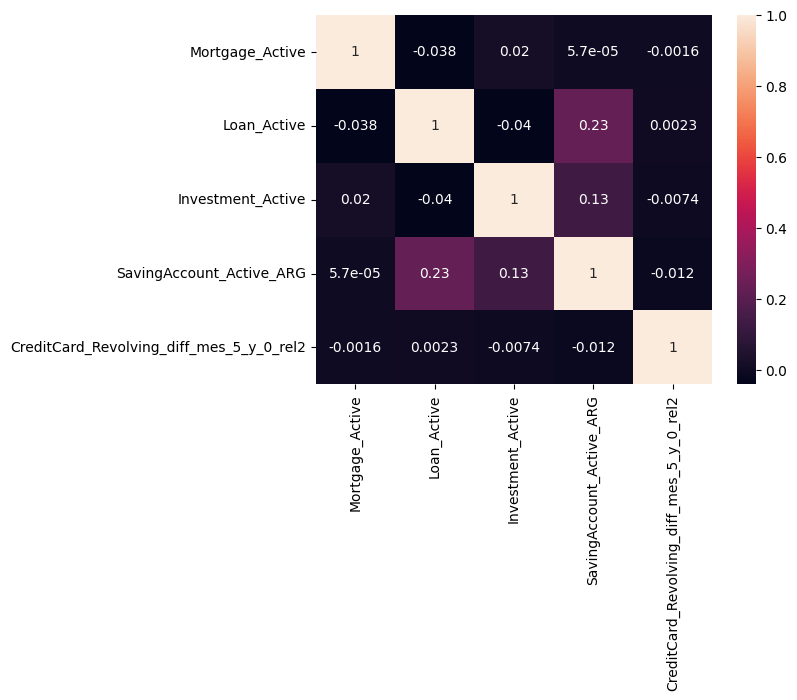

In [180]:
sns.heatmap(corr, annot=True)

In [181]:
corr = ABT.corr()
corr.head(10)

,client_id,TGT_x,CreditCard_Premium,CreditCard_Active,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel,CreditCard_spend_installments_ratio_diff_mes_5_y_0_rel2,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel2,CreditCard_Utilization_Rate_diff_mes_5_y_0_abs,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel,CreditCard_Utilization_Rate_diff_mes_5_y_0_rel2,CreditCard_utilization_diff_mes_5_y_0_abs_bin
client_id,1.000000,-0.048465,0.044398,-0.148117,0.008420,-0.125800,0.076811,0.179497,0.045123,0.149141,...,-0.004900,-0.007639,0.007639,-0.004747,-0.006158,0.006158,-0.012724,0.003944,-0.003944,0.110650
TGT_x,-0.048465,1.000000,0.079683,0.374440,0.135903,-0.007481,0.213590,0.045188,0.078836,0.091495,...,0.006237,0.005341,-0.005341,-0.013095,-0.039011,0.039011,0.017416,0.005910,-0.005910,-0.187704
CreditCard_Premium,0.044398,0.079683,1.000000,0.254667,-0.007414,-0.015391,-0.059728,-0.135524,-0.071107,-0.099862,...,-0.003400,0.009572,-0.009572,0.001095,0.046150,-0.046150,0.026691,0.001586,-0.001586,-0.152123
CreditCard_Active,-0.148117,0.374440,0.254667,1.000000,0.038196,-0.052002,-0.054037,-0.401302,-0.159098,-0.285630,...,-0.017936,-0.011059,0.011059,-0.028299,0.003286,-0.003286,0.052702,0.011039,-0.011039,-0.557429
Loan_Active,0.008420,0.135903,-0.007414,0.038196,1.000000,-0.037892,0.037689,0.231452,0.162303,0.223872,...,0.008256,-0.001167,0.001167,0.002501,-0.014895,0.014895,-0.008323,-0.002685,0.002685,-0.069377
Mortgage_Active,-0.125800,-0.007481,-0.015391,-0.052002,-0.037892,1.000000,0.026638,0.000057,0.022298,0.002179,...,0.003810,0.003754,-0.003754,0.001667,-0.003904,0.003904,-0.007577,-0.002903,0.002903,0.024648
SavingAccount_Active_ARG_Salary,0.076811,0.213590,-0.059728,-0.054037,0.037689,0.026638,1.000000,0.202671,0.144602,0.218246,...,0.003126,0.001235,-0.001235,0.002605,0.037385,-0.037385,-0.004460,-0.005922,0.005922,0.043065
SavingAccount_Active_ARG,0.179497,0.045188,-0.135524,-0.401302,0.231452,0.000057,0.202671,1.000000,0.572907,0.843082,...,0.013561,0.012274,-0.012274,0.000505,0.005534,-0.005534,-0.060668,-0.008590,0.008590,0.173833
SavingAccount_Active_DOLLAR,0.045123,0.078836,-0.071107,-0.159098,0.162303,0.022298,0.144602,0.572907,1.000000,0.538779,...,0.015593,0.007339,-0.007339,-0.000928,0.010340,-0.010340,-0.034692,-0.003646,0.003646,0.024122
DebitCard_Active,0.149141,0.091495,-0.099862,-0.285630,0.223872,0.002179,0.218246,0.843082,0.538779,1.000000,...,0.013048,0.012256,-0.012256,0.000118,0.006594,-0.006594,-0.052187,-0.008302,0.008302,0.106480


In [182]:
[x for x in ABT.columns if x.find('T') >= 0]

['TGT_x',
 'TGT_y',
 'SavingAccount_Salary_Payment_Transactions_sum',
 'SavingAccount_Salary_Payment_Transactions_max',
 'SavingAccount_Salary_Payment_Transactions_min',
 'SavingAccount_Salary_Payment_Transactions_mean',
 'SavingAccount_Salary_Payment_Transactions_median',
 'SavingAccount_Salary_Payment_Transactions_nunique',
 'SavingAccount_Salary_Payment_Transactions_std',
 'SavingAccount_Salary_Payment_Transactions_var',
 'SavingAccount_Salary_Payment_Transactions_ptp',
 'SavingAccount_Transfer_In_Transactions_sum',
 'SavingAccount_Transfer_In_Transactions_max',
 'SavingAccount_Transfer_In_Transactions_min',
 'SavingAccount_Transfer_In_Transactions_mean',
 'SavingAccount_Transfer_In_Transactions_median',
 'SavingAccount_Transfer_In_Transactions_nunique',
 'SavingAccount_Transfer_In_Transactions_std',
 'SavingAccount_Transfer_In_Transactions_var',
 'SavingAccount_Transfer_In_Transactions_ptp',
 'SavingAccount_ATM_Extraction_Transactions_sum',
 'SavingAccount_ATM_Extraction_Transactio

In [183]:
data_TGT.columns

Index(['client_id', 'TGT'], dtype='object')

In [184]:
%%script false
# Create correlation matrix
#corr_matrix = ABT.drop(['client_id', 'TGT_x'], axis=1).corr().abs()

corr_matrix = ABT

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).fillna(0)

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
## Esto elimina todas las columnas que tenemos, tienen mucha correlación, voy a subirlo a 0.95 para tener mas columnas con las cuales trabajar
print(len(to_drop))

ABT.shape

# Drop features
ABT.drop(to_drop, axis=1, inplace = True)

ABT.shape

CalledProcessError: Command 'b"# Create correlation matrix\n#corr_matrix = ABT.drop(['client_id', 'TGT_x'], axis=1).corr().abs()\n\ncorr_matrix = ABT\n\n# Select upper triangle of correlation matrix\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).fillna(0)\n\n# Find features with correlation greater than 0.95\nto_drop = [column for column in upper.columns if any(upper[column] > 0.95)]\n## Esto elimina todas las columnas que tenemos, tienen mucha correlaci\xc3\xb3n, voy a subirlo a 0.95 para tener mas columnas con las cuales trabajar\nprint(len(to_drop))\n\nABT.shape\n\n# Drop features\nABT.drop(to_drop, axis=1, inplace = True)\n\nABT.shape\n"' returned non-zero exit status 1.

In [185]:
# Calcular matriz de correlación absoluta
corr_matrix = ABT.drop(['client_id', 'TGT_x'], axis=1, errors='ignore').corr().abs()

# Seleccionar triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar columnas con correlación > 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"Columnas con alta correlación: {len(to_drop)}")
print(to_drop[:10])  # muestra las primeras 10

# Eliminar las columnas
ABT.drop(columns=to_drop, inplace=True, errors='ignore')

print("Nuevo shape:", ABT.shape)


Columnas con alta correlación: 273
['CreditCard_Product_tgt', 'SavingAccount_Balance_FirstDate_max', 'SavingAccount_Balance_FirstDate_mean', 'SavingAccount_Balance_FirstDate_median', 'SavingAccount_Balance_FirstDate_std', 'SavingAccount_Balance_FirstDate_ptp', 'SavingAccount_Balance_LastDate_sum', 'SavingAccount_Balance_LastDate_max', 'SavingAccount_Balance_LastDate_min', 'SavingAccount_Balance_LastDate_mean']
Nuevo shape: (23191, 138)


In [186]:
to_drop

['CreditCard_Product_tgt',
 'SavingAccount_Balance_FirstDate_max',
 'SavingAccount_Balance_FirstDate_mean',
 'SavingAccount_Balance_FirstDate_median',
 'SavingAccount_Balance_FirstDate_std',
 'SavingAccount_Balance_FirstDate_ptp',
 'SavingAccount_Balance_LastDate_sum',
 'SavingAccount_Balance_LastDate_max',
 'SavingAccount_Balance_LastDate_min',
 'SavingAccount_Balance_LastDate_mean',
 'SavingAccount_Balance_LastDate_median',
 'SavingAccount_Balance_LastDate_nunique',
 'SavingAccount_Balance_LastDate_std',
 'SavingAccount_Balance_LastDate_var',
 'SavingAccount_Balance_LastDate_ptp',
 'SavingAccount_Balance_Average_max',
 'SavingAccount_Balance_Average_min',
 'SavingAccount_Balance_Average_mean',
 'SavingAccount_Balance_Average_median',
 'SavingAccount_Balance_Average_nunique',
 'SavingAccount_Balance_Average_std',
 'SavingAccount_Balance_Average_var',
 'SavingAccount_Balance_Average_ptp',
 'SavingAccount_Days_with_use_max',
 'SavingAccount_Days_with_use_min',
 'SavingAccount_Days_with_

In [187]:
ABT.head(10)

,client_id,TGT_x,CreditCard_Premium,CreditCard_Active,Loan_Active,Mortgage_Active,SavingAccount_Active_ARG_Salary,SavingAccount_Active_ARG,SavingAccount_Active_DOLLAR,DebitCard_Active,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,1.0,0,1,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.078784,-0.145541,-0.000056,0.590410,3
1,6371753,0.0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
2,5928737,0.0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
3,475064,0.0,0,1,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,-0.006598,0.052916,0.000093,1.298107,2
4,3615172,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
5,6412264,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
6,6318899,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
7,7272795,1.0,0,1,1,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
8,4976363,0.0,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,4
9,5775560,0.0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,-0.009489,NaN,0.000000,NaN,2


# PCA

### Define Standard scaler and fit to the data_scaled

In [188]:
num_cols = ABT.select_dtypes(include=['float64','int64','Float64','Int64']).columns
cols_to_scale = [c for c in num_cols if c not in ['client_id','TGT','TGT_x','TGT_y']]

X = ABT[cols_to_scale]

# Qué columnas tienen inf / -inf / NaN
bad_inf = X.columns[np.isinf(X.to_numpy()).any(axis=0)].tolist()
bad_nan = X.columns[X.isna().any(axis=0)].tolist()
print("Con inf:", bad_inf[:10], "… total:", len(bad_inf))
print("Con NaN:", bad_nan[:10], "… total:", len(bad_nan))

Con inf: ['SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_Credits_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_Debits_diff_mes_5_y_0_rel', 'SavingAccount_Transfer_In_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_ATM_Extraction_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_Service_Payment_Transactions_diff_mes_5_y_0_rel', 'SavingAccount_CreditCard_Payment_Transactions_diff_mes_5_y_0_rel'] … total: 29
Con NaN: ['SavingAccount_use_ratio_max', 'SavingAccount_use_ratio_min', 'SavingAccount_use_ratio_mean', 'SavingAccount_use_ratio_median', 'SavingAccount_use_ratio_std', 'SavingAccount_Balance_FirstDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_LastDate_diff_mes_5_y_0_rel', 'SavingAccount_Balance_Average_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_use_diff_mes_5_y_0_rel', 'SavingAccount_Days_with_C

In [189]:
# Reemplazar inf por NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Imputar NaN con mediana (robusto) y asegurar float64
X = X.apply(lambda s: s.fillna(s.median())).astype('float64')

# recortar outliers extremos por percentiles (winsorización)
lower = X.quantile(0.001)
upper = X.quantile(0.999)
X = X.clip(lower=lower, upper=upper, axis=1)

In [190]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(X)
ABT_scaled = pd.DataFrame(data_scaled, columns=X.columns, index=ABT.index)

In [191]:
ABT_scaled.head(10)

,Client_Age_grp_tgt,Region_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,SavingAccount_Salary_Payment_Transactions_sum,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,2.771773,1.521506,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,0.091215,-1.698636,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,2.771773,0.090332,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,-0.645939,-1.698636,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,-0.645939,0.090332,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,-0.11126,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,0.091215,0.090332,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,1.38800,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,-0.645939,0.090332,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,0.63837,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,-0.645939,0.090332,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,1.38800,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,-0.645939,-1.698636,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


In [192]:
print(len(ABT), len(data_scaled))

23191 23191


In [193]:
# Ahora sí, concatená con client_id
ABT = pd.concat(
    [
        ABT[['client_id']].reset_index(drop=True),
        ABT_scaled.reset_index(drop=True)
    ],
    axis=1
)

In [194]:
ABT.head(10)

,client_id,Client_Age_grp_tgt,Region_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,2.771773,1.521506,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,6371753,0.091215,-1.698636,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,5928737,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,475064,2.771773,0.090332,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,3615172,-0.645939,-1.698636,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,6412264,-0.645939,0.090332,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,-0.11126,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,6318899,0.091215,0.090332,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,7272795,-0.645939,0.090332,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,0.63837,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,4976363,-0.645939,0.090332,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,5775560,-0.645939,-1.698636,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


### Define PCA with n components and random_state =1 and fit to the scaled data.

In [195]:
#Importing PCA and TSNE
from sklearn.decomposition import PCA

#Defining the number of principal components to generate
n = data_scaled.shape[1]

#Finding principal components for the data
pca1 = PCA(n_components=n, random_state=1)
data_pca = pd.DataFrame(pca1.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var1 = pca1.explained_variance_ratio_

In [196]:
n

125

Text(0, 0.5, 'Cumulative Explained Variance')

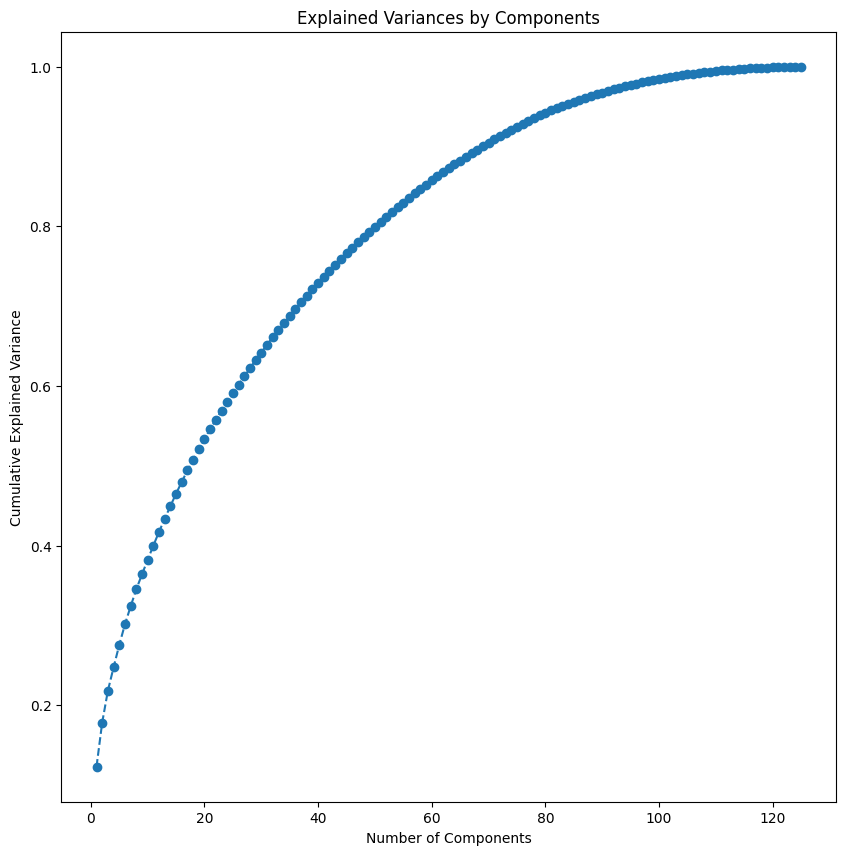

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

# visulaize the explained variance by individual components
plt.figure(figsize = (10,10))
plt.plot(range(1,n+1), pca1.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

### Si tengo 5 componentes obtengo el 60% de la informacion de las 29 variables de entrada

### How many Principal components explains more than X% variance in the dataset


In [198]:
# find the least number of components that can explain more than 80% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.80):
    print("Number of PCs that explain at least 80% variance: ", ix+1)
    break

Number of PCs that explain at least 80% variance:  51


de 29 variables paso a 8 y pierdo 30% de información

In [199]:
# find the least number of components that can explain more than 80% variance
sum = 0
for ix, i in enumerate(exp_var1):
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  37


In [200]:
cols_pca = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

feat_cols = [f'feat_{i}' for i in range(data_scaled.shape[1])]  # 16 genéricos
data_scaled = pd.DataFrame(data_scaled, columns=feat_cols)

pc1 = pd.DataFrame(
    np.round(pca1.components_.T[:, 0:6], 2),
    index=data_scaled.columns,
    columns=cols_pca
)


In [201]:
pca1.components_

array([[-2.35525711e-02, -1.28182336e-03,  1.42956632e-01, ...,
         1.35985055e-02,  1.68290366e-02, -2.11875281e-02],
       [ 4.32685276e-03, -6.71665872e-03, -4.40372318e-02, ...,
         2.31326446e-02, -3.15116179e-03,  1.44315821e-02],
       [ 9.27025659e-03,  1.16227573e-02,  1.34012634e-01, ...,
        -2.72425525e-02, -4.00468274e-02,  3.98573355e-02],
       ...,
       [-7.26773583e-04, -1.01464389e-03,  7.72257981e-03, ...,
        -3.74391833e-03,  3.51509806e-03, -6.29376483e-04],
       [-9.49275158e-04, -1.41409752e-03, -1.84291194e-02, ...,
        -4.80160846e-04, -5.75309879e-05,  7.59619030e-04],
       [-4.83587870e-17, -1.43377860e-17, -1.62435112e-17, ...,
         0.00000000e+00,  6.93889390e-17, -1.21430643e-16]],
      shape=(125, 125))

### Interpretation of coefficients of principal components from the below dataframe.

In [202]:
def color_high(val):
    if val <= -0.25: # you can decide any value as per your understanding
        return 'background: pink'
    elif val >= 0.25:
        return 'background: skyblue'

pc1.style.applymap(color_high)

/tmp/ipykernel_7618/2896165200.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pc1.style.applymap(color_high)


,PC1,PC2,PC3,PC4,PC5,PC6
feat_0,-0.020000,0.000000,0.010000,0.030000,-0.020000,0.070000
feat_1,-0.000000,-0.010000,0.010000,0.030000,-0.000000,0.040000
feat_2,0.140000,-0.040000,0.130000,0.040000,-0.030000,0.100000
feat_3,0.110000,-0.030000,0.150000,0.030000,-0.010000,0.050000
feat_4,0.150000,-0.040000,-0.100000,-0.110000,0.100000,-0.210000
feat_5,0.060000,-0.030000,0.050000,0.040000,-0.050000,0.140000
feat_6,0.180000,-0.040000,0.100000,0.010000,-0.010000,0.010000
feat_7,0.220000,-0.040000,-0.000000,-0.070000,0.060000,-0.160000
feat_8,0.120000,-0.020000,-0.140000,-0.130000,0.130000,-0.170000
feat_9,0.130000,0.010000,0.220000,-0.080000,0.080000,-0.120000


Luego de este analisis, hay que borrar de la ABT las 29 columnas y quedarse con los 8 PCA que quiero....

# Class 5 - Feature Selection

In [203]:
ABT.head(10)

,client_id,Client_Age_grp_tgt,Region_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,...,CreditCard_Payment_External_diff_mes_5_y_0_abs,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_rel,CreditCard_utilization_diff_mes_5_y_0_abs_bin
0,5856970,2.771773,1.521506,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,-0.325012,0.221044
1,6371753,0.091215,-1.698636,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
2,5928737,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
3,475064,2.771773,0.090332,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,0.583703,-0.617122
4,3615172,-0.645939,-1.698636,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
5,6412264,-0.645939,0.090332,-0.160273,-0.122425,1.198975,-0.079852,-0.151293,0.426529,-0.11126,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
6,6318899,0.091215,0.090332,0.209721,-0.186258,1.198975,-0.052403,-0.297967,0.854569,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
7,7272795,-0.645939,0.090332,-0.253463,-0.181554,1.198975,-0.080088,-0.318973,0.266014,0.63837,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
8,4976363,-0.645939,0.090332,1.243640,0.360581,1.198975,0.571636,2.249130,0.212509,1.38800,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,-0.073551,1.059209
9,5775560,-0.645939,-1.698636,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,...,0.12959,-0.041926,-0.042772,-0.027974,-0.042541,-0.301953,0.047816,-0.056911,-0.073551,-0.617122


In [204]:
ABT['TGT'] = ABT_backup['TGT_x']


ABT['idx'] = ABT['client_id']

In [205]:
# borro las categoricas... pero ustedes tienen que transformarlas!!!!!

b = [x for x in ABT.columns if x.find('Active') >= 0]
b += [x for x in ABT.columns if x.endswith('_rel') ]

ABT.drop(b, axis=1, inplace= True)

In [206]:
ABT.columns

Index(['client_id', 'Client_Age_grp_tgt', 'Region_tgt',
       'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_var',
       'SavingAccount_Balance_Average_sum', 'SavingAccount_Days_with_use_sum',
       'SavingAccount_Days_with_use_nunique',
       'SavingAccount_Salary_Payment_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_nunique',
       'SavingAccount_Transfer_In_Transactions_var',
       'SavingAccount_ATM_Extraction_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_var',
       'SavingAccount_CreditCard_Payment_Transactions_sum',
       'SavingAccount_CreditCard_Payment_Transactions_var',
       'SavingAccount_Transfer_Out_Transactions_sum',
       'SavingAccount_Transfer_Out_Transactions_nunique',
       'Sa

In [207]:
cols = ['client_id']
ABT.drop(cols, axis=1, inplace= True)

### Standarization

In [208]:
%%script false ## Ya todo esto de scaling lo hicimos arriba y esta en ABT ya.
ABT_Model = ABT.copy()

cols = ['idx']
ABT_Model.drop(cols, axis=1, inplace=True)

# to scale the data using z-score
names = [x for x in ABT_Model.columns if (x != 'client_id') & (x != 'TGT')]

# --- 0) Copia de trabajo
X = ABT_Model[names].copy()

# --- 1) Asegurar numérico (convierte strings a NaN si no son números)
X = X.apply(pd.to_numeric, errors='coerce')

# --- 2) Quitar infinitos y resolver NaN (SIN mediana: constante 0)
#     (antes usabas 'x' sin definir; aquí usamos 'X' consistente)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# --- 3) Scaler: primero fit con la matriz LIMPIA y luego transform sobre la MISMA matriz
scaler = StandardScaler(copy=True)
scaler.fit(X)                 # Entrena con X limpio (equivalente a lo del profesor)
scaled_est = scaler.transform(X)  # Estandariza el total de la base (ya limpio)

# --- 4) Devolver al DataFrame con mismos índices/columnas
scaled_est = pd.DataFrame(scaled_est, columns=names, index=ABT_Model.index)

ABT_Model.drop(names, axis=1, inplace=True)
ABT_Model = pd.concat((ABT_Model, scaled_est), axis=1, sort=False)

ABT_Model.head(5)


CalledProcessError: Command 'b"ABT_Model = ABT.copy()\n\ncols = ['idx']\nABT_Model.drop(cols, axis=1, inplace=True)\n\n# to scale the data using z-score\nnames = [x for x in ABT_Model.columns if (x != 'client_id') & (x != 'TGT')]\n\n# --- 0) Copia de trabajo\nX = ABT_Model[names].copy()\n\n# --- 1) Asegurar num\xc3\xa9rico (convierte strings a NaN si no son n\xc3\xbameros)\nX = X.apply(pd.to_numeric, errors='coerce')\n\n# --- 2) Quitar infinitos y resolver NaN (SIN mediana: constante 0)\n#     (antes usabas 'x' sin definir; aqu\xc3\xad usamos 'X' consistente)\nX = X.replace([np.inf, -np.inf], np.nan)\nX = X.fillna(0)\n\n# --- 3) Scaler: primero fit con la matriz LIMPIA y luego transform sobre la MISMA matriz\nscaler = StandardScaler(copy=True)\nscaler.fit(X)                 # Entrena con X limpio (equivalente a lo del profesor)\nscaled_est = scaler.transform(X)  # Estandariza el total de la base (ya limpio)\n\n# --- 4) Devolver al DataFrame con mismos \xc3\xadndices/columnas\nscaled_est = pd.DataFrame(scaled_est, columns=names, index=ABT_Model.index)\n\nABT_Model.drop(names, axis=1, inplace=True)\nABT_Model = pd.concat((ABT_Model, scaled_est), axis=1, sort=False)\n\nABT_Model.head(5)\n"' returned non-zero exit status 1.

In [209]:
ABT_Model = ABT.copy()
ABT_Model.head(5)

,Client_Age_grp_tgt,Region_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,SavingAccount_Salary_Payment_Transactions_sum,...,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs_bin,TGT,idx
0,2.771773,1.521506,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,0.221044,1.0,5856970
1,0.091215,-1.698636,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,6371753
2,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,5928737
3,2.771773,0.090332,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,-0.617122,0.0,475064
4,-0.645939,-1.698636,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,3615172


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.794403	valid_0's binary_logloss: 0.501188
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.794112	valid_0's binary_logloss: 0.498164
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's auc: 0.791191	valid_0's binary_logloss: 0.502143
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.79362	valid_0's binary_logloss: 0.50071
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.793565	valid_0's binary_logloss: 0.499428
Training until validation scores don't improve for 100 rounds
Did not

<Axes: >

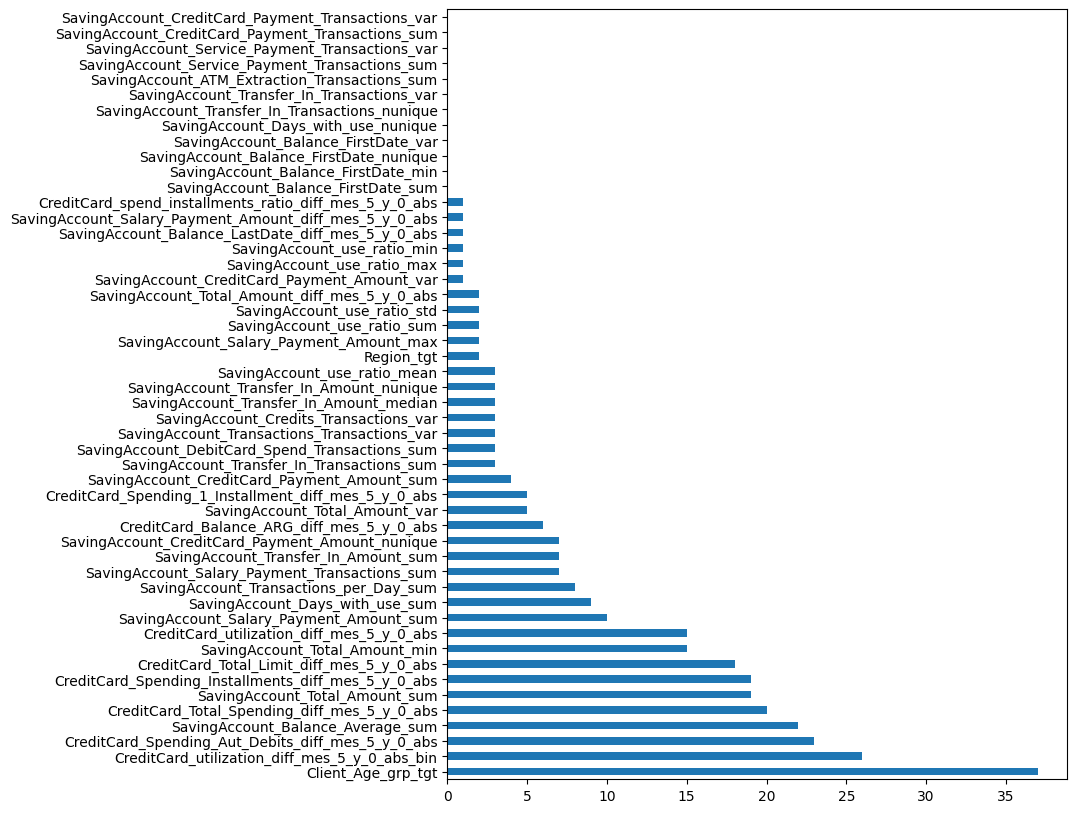

In [210]:
target_column = 'TGT'
numerical_cols = [x for x in ABT_Model.columns if (x != 'idx') & (x != 'TGT') ]

# ========= Cambios mínimos en fit_params =========
# - Reemplazo early_stopping_rounds y verbose por callbacks (compatibles v3/v4)
fit_params = {
    "eval_metric": "auc",
    "eval_set": [(ABT_Model[numerical_cols], ABT_Model[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

# Tu espacio de búsqueda tal cual (subsample = bagging_fraction alias)
param_test = {
    'num_leaves': np.arange(15, 20, 1),
    'min_data_in_leaf': np.arange(1000, 3000, 100),
    'subsample': sp_uniform(loc=0.2, scale=0.8),
    'max_depth': np.arange(6, 10, 1),
    'n_estimators': np.arange(15, 20, 1)
}

n_HP_points_to_test = 100

# ========= Clasificador (parámetros válidos en sklearn wrapper) =========
clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=4,
    verbosity=-1  # sustituye a 'silent'
    # no 'metric' aquí; se pasa en fit como eval_metric
    # no 'nfold' aquí; eso es de lgb.cv, no del wrapper sklearn
)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=1
)

# IMPORTANTE: los datos deben ser NUMÉRICOS y finitos (ya los limpiaste arriba)
gs.fit(ABT_Model[numerical_cols], ABT_Model[target_column], **fit_params)

feat_imp = pd.Series(gs.best_estimator_.feature_importances_, index=ABT_Model[numerical_cols].columns)
feat_imp.nlargest(50).plot(kind='barh', figsize=(8,10))


In [211]:
a = pd.DataFrame(feat_imp.nlargest(50))
a

,0
Client_Age_grp_tgt,37
CreditCard_utilization_diff_mes_5_y_0_abs_bin,26
CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs,23
SavingAccount_Balance_Average_sum,22
CreditCard_Total_Spending_diff_mes_5_y_0_abs,20
SavingAccount_Total_Amount_sum,19
CreditCard_Spending_Installments_diff_mes_5_y_0_abs,19
CreditCard_Total_Limit_diff_mes_5_y_0_abs,18
SavingAccount_Total_Amount_min,15
CreditCard_utilization_diff_mes_5_y_0_abs,15


### Bivariados

In [212]:
#ABT['idx'] = ABT['client_id']
# ABT['TGT'] = ABT['TGT_x']
ABT

,Client_Age_grp_tgt,Region_tgt,SavingAccount_Balance_FirstDate_sum,SavingAccount_Balance_FirstDate_min,SavingAccount_Balance_FirstDate_nunique,SavingAccount_Balance_FirstDate_var,SavingAccount_Balance_Average_sum,SavingAccount_Days_with_use_sum,SavingAccount_Days_with_use_nunique,SavingAccount_Salary_Payment_Transactions_sum,...,CreditCard_Payment_Cash_diff_mes_5_y_0_abs,CreditCard_Payment_Web_diff_mes_5_y_0_abs,CreditCard_Payment_ATM_diff_mes_5_y_0_abs,CreditCard_Payment_TAS_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs,CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs,CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs,CreditCard_utilization_diff_mes_5_y_0_abs_bin,TGT,idx
0,2.771773,1.521506,-0.252552,-0.186258,1.198975,-0.080085,-0.135684,0.961579,1.38800,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,0.893070,-0.515485,-0.138488,0.221044,1.0,5856970
1,0.091215,-1.698636,-0.206547,-0.179020,1.198975,-0.079259,-0.345334,0.373024,1.38800,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,6371753
2,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,5928737
3,2.771773,0.090332,-0.094643,-0.133371,1.198975,-0.077381,-0.048621,0.212509,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.262819,0.252622,0.077194,-0.617122,0.0,475064
4,-0.645939,-1.698636,-0.257098,-0.186207,-0.967401,-0.080089,-0.438504,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,3615172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23186,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,-0.041926,3.177797,-0.027974,-0.042541,-1.838240,3.125787,-0.056911,-0.617122,0.0,4221845
23187,-0.645939,1.521506,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,0.245788,0.047816,-0.056911,-0.617122,0.0,1988103
23188,-0.645939,-1.698636,-0.161449,0.014668,1.198975,-0.080089,-0.146594,0.105499,-0.11126,-0.285424,...,-0.041926,-0.042772,-0.027974,-0.042541,-0.137579,0.047816,-0.056911,1.059209,0.0,4908119
23189,-0.645939,0.090332,-0.257122,-0.186258,-0.967401,-0.080089,-0.438574,-0.750581,-0.86089,-0.285424,...,-0.041926,-0.042772,-0.027974,6.447981,-0.624690,0.047816,-0.056911,-0.617122,1.0,3028372


## transformo con bivariados Operations_Telemarketer_sum


In [213]:
ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] = np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 0, 0 ,
                                               np.where(ABT['CreditCard_utilization_diff_mes_5_y_0_abs'] == 42,  42,

                                               100
                                               )

                                               )


ABT['CreditCard_utilization_diff_mes_5_y_0_abs'].value_counts()

CreditCard_utilization_diff_mes_5_y_0_abs
100    23191
Name: count, dtype: int64

# Clase 6

In [214]:
ABT = ABT.fillna(0)

In [215]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(ABT, test_size=0.3, random_state=42, stratify=ABT['TGT']);

In [216]:
type(X_train)

pandas.core.frame.DataFrame

In [217]:
ABT.shape

(23191, 98)

In [218]:
X_train.shape

(16233, 98)

In [219]:
 np.arange(6, 20, 1),

(array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),)

In [220]:
 np.arange(6, 20, 2),

(array([ 6,  8, 10, 12, 14, 16, 18]),)

In [221]:
ABT.columns

Index(['Client_Age_grp_tgt', 'Region_tgt',
       'SavingAccount_Balance_FirstDate_sum',
       'SavingAccount_Balance_FirstDate_min',
       'SavingAccount_Balance_FirstDate_nunique',
       'SavingAccount_Balance_FirstDate_var',
       'SavingAccount_Balance_Average_sum', 'SavingAccount_Days_with_use_sum',
       'SavingAccount_Days_with_use_nunique',
       'SavingAccount_Salary_Payment_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_sum',
       'SavingAccount_Transfer_In_Transactions_nunique',
       'SavingAccount_Transfer_In_Transactions_var',
       'SavingAccount_ATM_Extraction_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_sum',
       'SavingAccount_Service_Payment_Transactions_var',
       'SavingAccount_CreditCard_Payment_Transactions_sum',
       'SavingAccount_CreditCard_Payment_Transactions_var',
       'SavingAccount_Transfer_Out_Transactions_sum',
       'SavingAccount_Transfer_Out_Transactions_nunique',
       'SavingAccount_D

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.792983	valid_0's binary_logloss: 0.521051
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.791964	valid_0's binary_logloss: 0.521753
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.791671	valid_0's binary_logloss: 0.523949
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.794555	valid_0's binary_logloss: 0.501838
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.793346	valid_0's binary_logloss: 0.501994
Training until validation scores don't improve for 100 rounds
Did not mee

<Axes: >

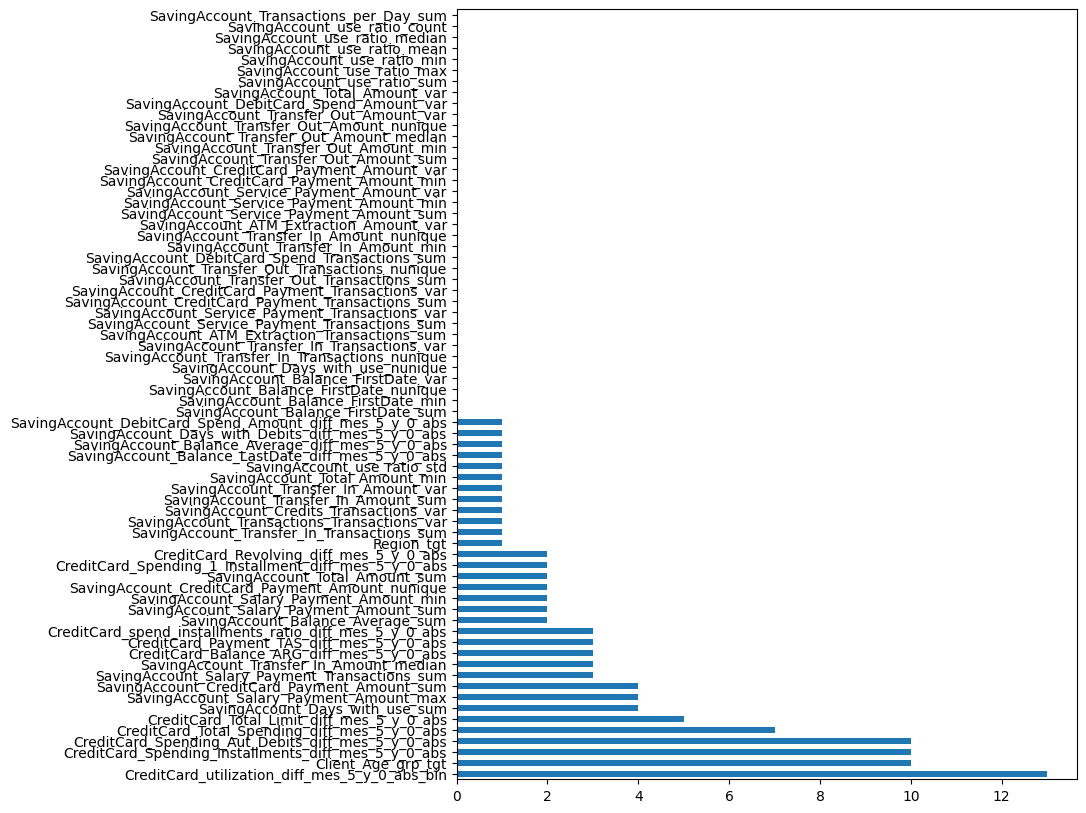

In [222]:
target_column = 'TGT'
numerical_cols = list(ABT.drop(['TGT', 'idx'], axis=1).columns)

# === fit_params: reemplazo early_stopping_rounds/verbose por callbacks ===
fit_params = {
    "eval_metric": "auc",
    "eval_set": [(X_test[numerical_cols], X_test[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

param_test = {
    'num_leaves': np.arange(3, 8, 1),
    'min_child_samples': np.arange(300, 500, 100),
    'max_depth': np.arange(4, 10, 1),
    'n_estimators': np.arange(6, 20, 1),
    'learning_rate': [0.05, 0.1, 0.2, 0.01]
}

# This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50

# n_estimators is set to a "large value". The actual number of trees build will depend on early stopping
clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=4,
    verbosity=-1,      # reemplaza a 'silent=True'
    # metric va en fit via eval_metric; aquí no es necesario
)

cross_val = StratifiedKFold(n_splits=3)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=cross_val,
    refit=True,
    random_state=314,
    verbose=True
)

gs.fit(X_train[numerical_cols], X_train[target_column], **fit_params)

feat_imp = pd.Series(
    gs.best_estimator_.feature_importances_,
    index=X_train[numerical_cols].columns
)
feat_imp.nlargest(70).plot(kind='barh', figsize=(8,10))


In [223]:
len(numerical_cols)

96

In [224]:
feat_imp

Client_Age_grp_tgt                                        10
Region_tgt                                                 1
SavingAccount_Balance_FirstDate_sum                        0
SavingAccount_Balance_FirstDate_min                        0
SavingAccount_Balance_FirstDate_nunique                    0
                                                          ..
CreditCard_Payment_TAS_diff_mes_5_y_0_abs                  3
CreditCard_utilization_diff_mes_5_y_0_abs                  0
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs     3
CreditCard_auto_debit_ratio_diff_mes_5_y_0_abs             0
CreditCard_utilization_diff_mes_5_y_0_abs_bin             13
Length: 96, dtype: int32

In [225]:
# These are the optimal hyperparameters...
opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': np.int64(6), 'min_child_samples': np.int64(400), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(18), 'n_jobs': 4, 'num_leaves': np.int64(7), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}


In [226]:
gs.best_estimator_

,boosting_type,'gbdt'
,num_leaves,np.int64(7)
,max_depth,np.int64(6)
,learning_rate,0.2
,n_estimators,np.int64(18)
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,np.int64(400)


In [227]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.8153855436298189 with params: {'num_leaves': np.int64(7), 'n_estimators': np.int64(18), 'min_child_samples': np.int64(400), 'max_depth': np.int64(6), 'learning_rate': 0.2} 


In [228]:
# These are the optimal hyperparameters...
opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': np.int64(6), 'min_child_samples': np.int64(400), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(18), 'n_jobs': 4, 'num_leaves': np.int64(7), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}


In [229]:
#Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())
print(clf.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'num_leaves': 31, 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}


## Vuelvo a correr con las mejores 20 features

CreditCard_utilization_diff_mes_5_y_0_abs_bin             13
Client_Age_grp_tgt                                        10
CreditCard_Spending_Installments_diff_mes_5_y_0_abs       10
CreditCard_Spending_Aut_Debits_diff_mes_5_y_0_abs         10
CreditCard_Total_Spending_diff_mes_5_y_0_abs               7
CreditCard_Total_Limit_diff_mes_5_y_0_abs                  5
SavingAccount_Days_with_use_sum                            4
SavingAccount_Salary_Payment_Amount_max                    4
SavingAccount_CreditCard_Payment_Amount_sum                4
SavingAccount_Salary_Payment_Transactions_sum              3
SavingAccount_Transfer_In_Amount_median                    3
CreditCard_Balance_ARG_diff_mes_5_y_0_abs                  3
CreditCard_Payment_TAS_diff_mes_5_y_0_abs                  3
CreditCard_spend_installments_ratio_diff_mes_5_y_0_abs     3
SavingAccount_Balance_Average_sum                          2
SavingAccount_Salary_Payment_Amount_sum                    2
SavingAccount_Salary_Pay

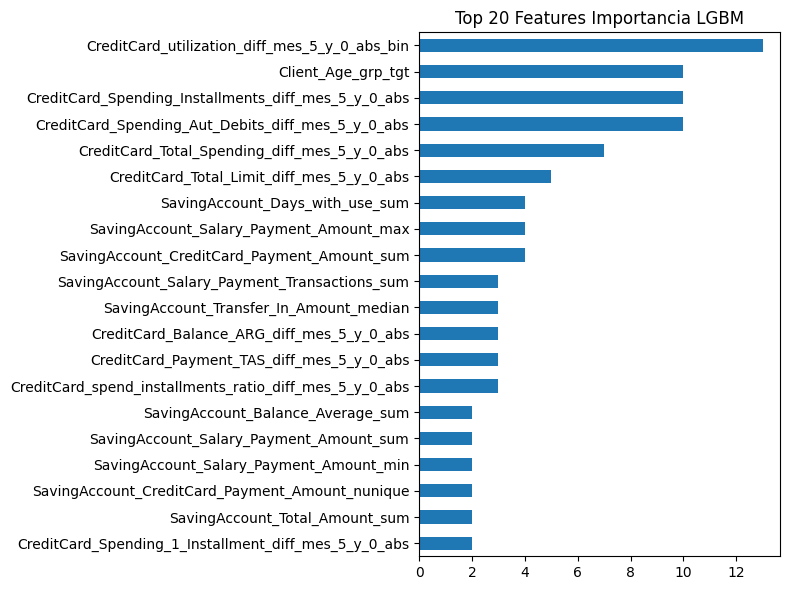

In [230]:
# === Top 20 features por importancia ya calculada en feat_imp ===
top20 = feat_imp.nlargest(20)                 # Serie: index=feature, values=importance
numerical_cols = top20.index.tolist()         # <-- nombres de columnas (no los valores)

print(top20)
ax = top20.plot(kind='barh', figsize=(8,6), title='Top 20 Features Importancia LGBM')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# === Alinear X_train / X_test a esas 20 columnas (por si falta alguna) ===
X_train_top = X_train.reindex(columns=numerical_cols, fill_value=0)
X_test_top  = X_test.reindex(columns=numerical_cols,  fill_value=0)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.795883	valid_0's binary_logloss: 0.527641
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.790809	valid_0's binary_logloss: 0.521769
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[7]	valid_0's auc: 0.791585	valid_0's binary_logloss: 0.523663
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.797626	valid_0's binary_logloss: 0.501287
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's auc: 0.797443	valid_0's binary_logloss: 0.501683
Training until validation scores don't improve for 100 rounds
Did not mee

<Axes: title={'center': 'Top 20 (reentrenado)'}>

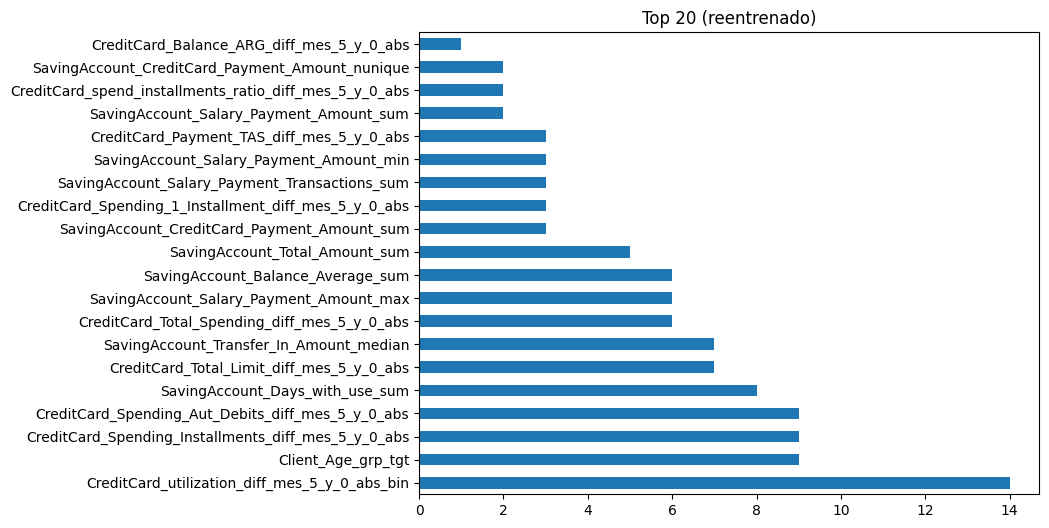

In [231]:
target_column = 'TGT'

fit_params = {
    "eval_metric": "auc",
    "eval_set": [(X_test_top, X_test[target_column])],
    "callbacks": [
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
}

param_test = {
    'num_leaves': np.arange(3, 8, 1),
    'min_child_samples': np.arange(300, 500, 100),
    'max_depth': np.arange(4, 10, 1),
    'n_estimators': np.arange(6, 20, 1),
    'learning_rate': [0.05, 0.1, 0.2, 0.01]
}

n_HP_points_to_test = 50

clf = lgb.LGBMClassifier(
    random_state=314,
    n_jobs=4,
    verbosity=-1  # reemplaza a silent=True
)

cross_val = StratifiedKFold(n_splits=3)

gs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=cross_val,
    refit=True,
    random_state=314,
    verbose=True
)

gs.fit(X_train_top, X_train[target_column], **fit_params)

# Importancias del mejor modelo y gráfico (sobre las 20 usadas)
feat_imp_top = pd.Series(gs.best_estimator_.feature_importances_, index=numerical_cols)
feat_imp_top.nlargest(20).plot(kind='barh', figsize=(8,6), title='Top 20 (reentrenado)')

In [232]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.8160245946938147 with params: {'num_leaves': np.int64(7), 'n_estimators': np.int64(18), 'min_child_samples': np.int64(400), 'max_depth': np.int64(6), 'learning_rate': 0.2} 


In [233]:
# These are the optimal hyperparameters...
opt_parameters = gs.best_estimator_.get_params()
print(opt_parameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': np.int64(6), 'min_child_samples': np.int64(400), 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': np.int64(18), 'n_jobs': 4, 'num_leaves': np.int64(7), 'objective': None, 'random_state': 314, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbosity': -1}


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[18]	valid_0's auc: 0.813493	valid_0's binary_logloss: 0.46563
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict({'auc': np.float64(0.8134933223195051), 'binary_logloss': np.float64(0.4656295902116295)})})


<Axes: >

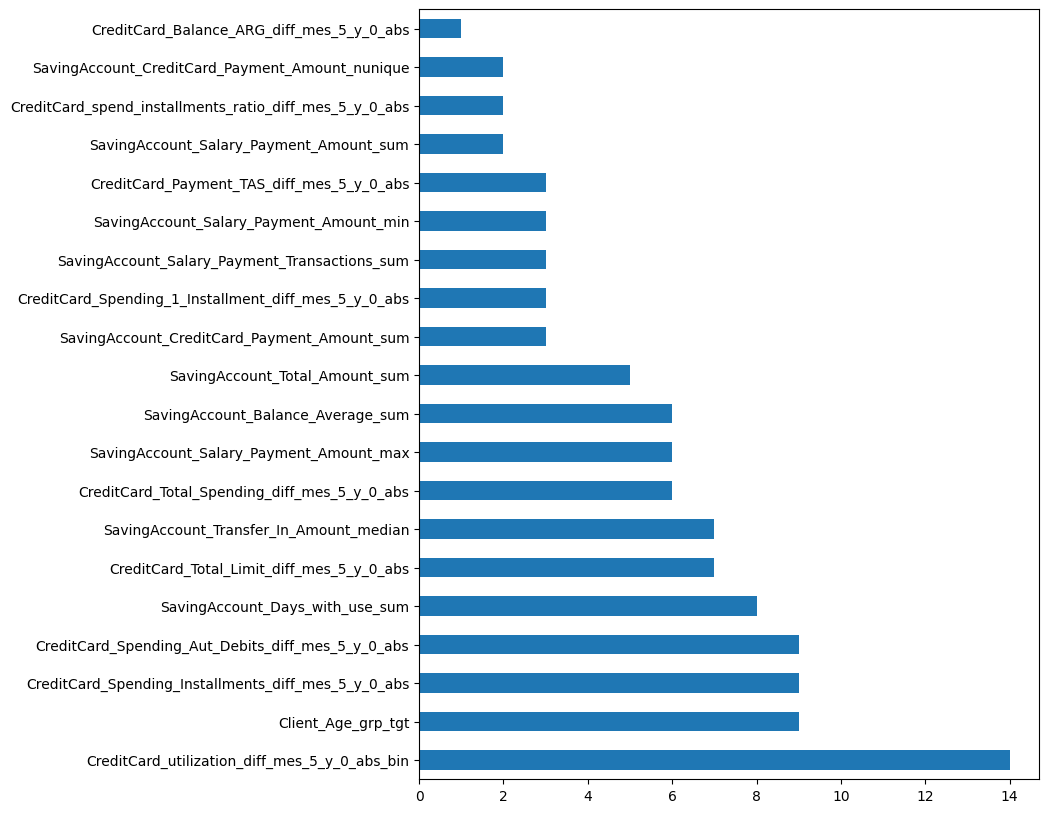

In [234]:
#set optimal parameters
clf_final.set_params(**opt_parameters)

#Train the final model with learning rate decay
clf_final_train = clf_final.fit(X_train[ numerical_cols ], X_train[target_column],
                                **fit_params )

print(clf_final_train.best_score_)

feat_imp = pd.Series(clf_final.feature_importances_, index=X_train[numerical_cols].columns)
feat_imp.nlargest(100).plot(kind='barh', figsize=(8,10))